# Libraries

In [1]:
import time
import pandas as pd
import numpy as np
import re

import json

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objs as go

# remove verison errors
import warnings
warnings.filterwarnings('ignore')

In [2]:
colors = ["#4374B3", "#FF8C37"]
cmap = sns.color_palette(colors)
cmap
sns.set_palette(cmap)

# Import CSV

In [3]:
path = 'repository/data_prep/Original_Appendicitis.csv'
knn_path = 'repository/data_prep/KNN_Appendicitis.csv'
iter_path = 'repository/data_prep/IterativeImputer_Appendicitis.csv'
# ---
og_df = pd.read_csv(path)
knn_df_imputed = pd.read_csv(knn_path)
interative_df_imputed = pd.read_csv(iter_path)

In [4]:
df_dict = {'Original': og_df,'KNN': knn_df_imputed,'IterativeImputer':interative_df_imputed}

### Considering Imputer to impute in Main DataFrame
<u>Anwser</u> The **density** of **KNN Imputer** is the most **similarities** to the Original data.

In [5]:
df = knn_df_imputed.copy()

# Dimensionality reduction
## What is Dimensionality reduction?
the process of reducing the number of variables, features, or dimensions in a dataset while preserving as much relevant information as possible. It aims to overcome the curse of dimensionality. On the other hand called reducing the dimensionality of a dataset.
## Problem
- **Training Time**
- High number of features can suffer from **increased computational** complexity, **overfitting**.
## Solution
- Feature Selection
- Feature Extraction
- Principal Component Analysis (PCA)
- etc.
## Benefit 
- Improved computational efficiency
    - speed up the training and inference processes of machine learning algorithms
- Elimination of noise and redundancy
    - remove irrelevant or noisy features, leading to better generalization and more robust models. 
    
## Robust model
- Outlier resistance
    - less sensitive to outliers, provide more reliable and accurate results even in the presence of outliers.
- Noise tolerance
    - handle noisy data, which may contain random or irrelevant variations. so model can perform well on unseen or new data that it has not been trained on. 
## Methods
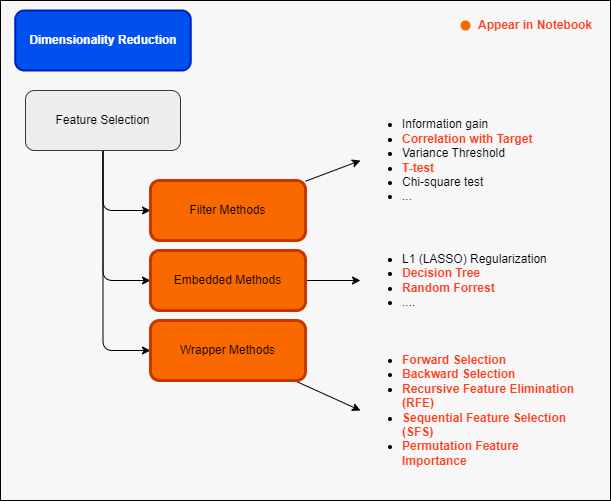

## Filter Method

### 1. Correlation with Target
- **0** to **1** = Positive relationship
- **0** = No relationship
- **0** to **-1** = Negative relationship

No relationship <u>means</u> no impact to **target**

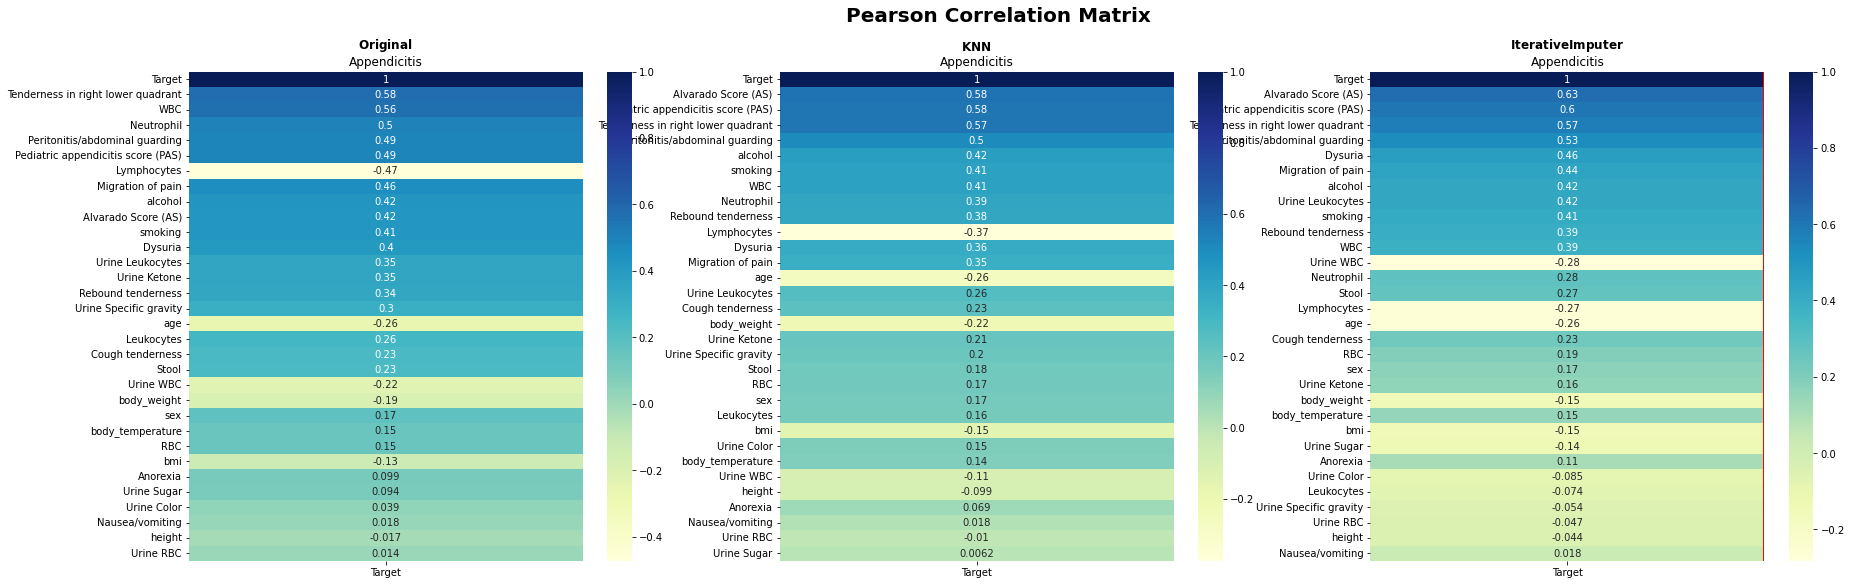

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(30, 9))
fig.suptitle('Pearson Correlation Matrix', fontsize=20, fontweight='bold')

index = 0
for name, df in df_dict.items():
    corr_matrix = df.corr()
    # Df section
    target_corr = corr_matrix['Target']
    other_corr = corr_matrix.drop('Target')['Target']
    corr_df = pd.DataFrame({'Target': target_corr})
    corr_df = corr_df.reindex(
        corr_df['Target'].abs().sort_values(ascending=False).index)
    # Graph Section
    axes[index].set_title(r'$\bf{' + name + '}$' +
                          f'\nAppendicitis')
    sns.heatmap(corr_df, cmap="YlGnBu", annot=True, ax=axes[index])
    plt.vlines(x=1, ymin=0, ymax=len(corr_df), colors='r', linewidth=2)
    index += 1
plt.show()

In [133]:
df_dict['KNN'].columns

Index(['age', 'sex', 'height', 'body_weight', 'bmi', 'body_temperature',
       'alcohol', 'smoking', 'WBC', 'RBC', 'Neutrophil', 'Lymphocytes',
       'Urine WBC', 'Urine RBC', 'Leukocytes', 'Urine Ketone', 'Urine Color',
       'Urine Sugar', 'Urine Leukocytes', 'Urine Specific gravity', 'Target',
       'Peritonitis/abdominal guarding', 'Migration of pain',
       'Tenderness in right lower quadrant', 'Rebound tenderness',
       'Cough tenderness', 'Nausea/vomiting', 'Anorexia', 'Dysuria', 'Stool',
       'Alvarado Score (AS)', 'Pediatric appendicitis score (PAS)'],
      dtype='object')

### 2. T-test
- **Obj**: calculate p-value with t-test on every features to identified as useful in appendicitis predicting
- **Outcome**: `Useful Features` , P-value can identify which features have a statistically significant impact on the target variable. 


#### Explanation
significantly (at level α = 0.05)
means 

**If** P-value of feature ≥ α 
-  Null hypothesis is true

**If** P-value of feature < α 
- Null hypothesis is false or should be rejected. (`Useful Features`)

 if the p-value of a feature is `less than` the `significance level`, it indicates that the feature is statistically significant and has a meaningful `impact` on the `target variable` in the classification model.

In [7]:
from scipy.stats import ttest_ind
dict_p_values = {'Original': '', 'KNN': '', 'IterativeImputer': ''}

# Loop through each feature column and calculate the t-test p-value
for name, df in df_dict.items():
    features = []
    p_value_s = []
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        group1 = df[df['Target'] == 0][col]
        group2 = df[df['Target'] == 1][col]
        t, p = ttest_ind(group1, group2)
        features.append(col)
        p_value_s.append(p)

    dict_pvalues = dict(zip(features, p_value_s))
    dict_p_values[name] = dict_pvalues


In [8]:
pavlue_df = pd.DataFrame(dict_p_values)
pavlue_df.style.background_gradient(cmap='Oranges')

In [9]:
pavlue_df[pavlue_df.columns] = pavlue_df[pavlue_df.columns].apply(
    lambda x: round(x, 6))
pavlue_df.style.background_gradient(cmap='Oranges')


#### Useful features

In [10]:
threshold = 0.05
pavlue_df.loc[pavlue_df['KNN'] < threshold][['KNN']
                                            ].style.background_gradient(cmap='Oranges')


## Feature Selection
| Concept | Objective | Pros | Cons | Outcome |
| --- | --- | --- | --- | --- |
| Reducing the dimensionality of data and `focusing on` the most `influential features` | Enhance model performance and interpretability | Improved model accuracy / Reduced Overfitting / Faster Training / Enhanced Interpretability | Information Loss: Removed features may contain relevant patterns or interactions with other features | Selection of informative features |

### 1. Forward Selection
| Concept | Objective | Pros | Cons | Outcome |
| --- | --- | --- | --- | --- |
| Starting with a minimal feature set and adding features `1 feature` - `N feature` | Identify the most informative features | Improved model accuracy / Reduced Overfitting / Enhanced Interpretability | Computationally Intensive for Large Feature Sets / May overlook relevant interactions between features | Selection of informative features |

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, r2_score, log_loss, roc_curve, roc_auc_score

In [12]:
# Separate X,Y
X = df.drop(['Target'], axis=1)
y = df['Target']
# Splitting (Train:Test = 80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### If the accuracy improved

In [13]:
performance_list = []
all_features = list(X.columns)
selected_features = []

best_accuracy = 0.0
for feature in all_features:
    model = LogisticRegression()
    # Reshape to 2D array
    selected_features.append(feature)
    X_train_feature = X_train.loc[:, selected_features]
    X_test_feature = X_test.loc[:, selected_features]  # Reshape to 2D array

    model.fit(X_train_feature, y_train)

    for subset, subset_name, y_true in [(X_train_feature, 'Train', y_train),
                                        (X_test_feature, 'Test', y_test)]:
        y_pred = model.predict(subset)
        # Performances
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred)
        # Classification Report
        report = classification_report(y_true, y_pred, output_dict=True)
        report_dict = json.loads(json.dumps(report))

        # Extract precision and recall from report_dict
        precision = report_dict['weighted avg']['precision']
        recall = report_dict['weighted avg']['recall']
        accuracy = report_dict['accuracy']
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        # Dict
        my_dict = {'Model': 'LogisticRegression', 'Feature': list(X_train_feature.columns), 'Performance': subset_name,
                   'AUC': auc_score, 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
                   'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            performance_list.append(my_dict)
        else:
            if not selected_features:
                selected_features.pop()

performances = pd.DataFrame(performance_list)
performances


Model                                            Feature  \
0   LogisticRegression                                              [age]   
1   LogisticRegression                                         [age, sex]   
2   LogisticRegression                                 [age, sex, height]   
3   LogisticRegression                    [age, sex, height, body_weight]   
4   LogisticRegression               [age, sex, height, body_weight, bmi]   
5   LogisticRegression  [age, sex, height, body_weight, bmi, body_temp...   
6   LogisticRegression  [age, sex, height, body_weight, bmi, body_temp...   
7   LogisticRegression  [age, sex, height, body_weight, bmi, body_temp...   
8   LogisticRegression  [age, sex, height, body_weight, bmi, body_temp...   
9   LogisticRegression  [age, sex, height, body_weight, bmi, body_temp...   
10  LogisticRegression  [age, sex, height, body_weight, bmi, body_temp...   
11  LogisticRegression  [age, sex, height, body_weight, bmi, body_temp...   
12  LogisticRegression  [age, sex, height, body_weight, bmi, body_temp...   
13  LogisticRegression  [age, sex, height, body_weight, bmi, body_temp...   

   Performance       AUC   TP   FP  FN   TN  Precision  Recall  Accuracy  
0        Train  0.561333   45  107  43  205   0.601690  0.6250    0.6250  
1        Train  0.566638   46  106  42  206   0.607995  0.6300    0.6300  
2        Train  0.587649   53   99  43  205   0.627884  0.6450    0.6450  
3        Train  0.599533   56   96  42  206   0.640057  0.6550    0.6550  
4        Train  0.612691   60   92  42  206   0.652120  0.6650    0.6650  
5        Train  0.734614   94   58  37  211   0.758991  0.7625    0.7625  
6        Train  0.796795  108   44  29  219   0.815836  0.8175    0.8175  
7        Train  0.837436  113   39  17  231   0.860752  0.8600    0.8600  
8        Train  0.841999  115   37  18  230   0.862654  0.8625    0.8625  
9        Train  0.846562  117   35  19  229   0.864715  0.8650    0.8650  
10       Train  0.849851  118   34  19  229   0.867147  0.8675    0.8675  
11       Train  0.855157  119   33  18  230   0.872278  0.8725    0.8725  
12       Train  0.854626  117   35  15  233   0.875848  0.8750    0.8750  
13       Train  0.897390  130   22  15  233   0.907199  0.9075    0.9075

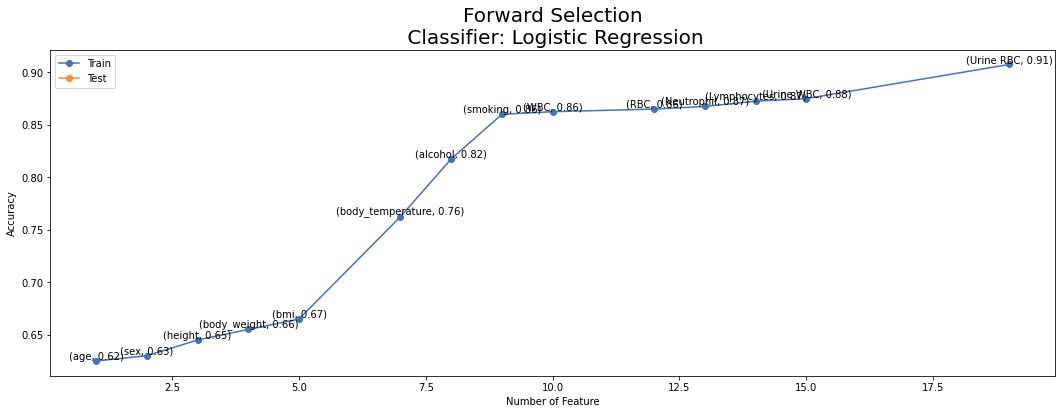

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))  # Adjust the width and height as needed

# Train
train_set_performances = performances.loc[performances['Performance'] == 'Train']
n_feature_train = train_set_performances['Feature'].apply(len)

# Test
test_set_performances = performances.loc[performances['Performance'] == 'Test']
n_feature_test = test_set_performances['Feature'].apply(len)

# Train Line
train_line, = plt.plot(
    n_feature_train, train_set_performances['Accuracy'], marker='o')

# Test Line
test_line, = plt.plot(
    n_feature_test, test_set_performances['Accuracy'], marker='o')

# Find Features
what_features = list(performances['Feature'])[-1]

# Add labels for markers in the train line
for x, a, z in zip(n_feature_train, train_set_performances['Accuracy'], what_features):
    plt.text(x, a, f'({z}, {round(a, 2)})', ha='center', va='bottom')

# Add labels for markers in the test line
for x, a,z in zip(n_feature_test, test_set_performances['Accuracy'], what_features):
    plt.text(x, a, f'({z}, {round(a, 2)})', ha='center', va='bottom')

# Set x-axis labels rotation
plt.xticks(rotation=0)

# Add labels and title
plt.xlabel('Number of Feature')
plt.ylabel('Accuracy')
plt.title('Forward Selection\n Classifier: Logistic Regression', fontsize=20)

# Add legend
plt.legend([train_line, test_line], ['Train', 'Test'], loc='best')

# Show the plot
plt.show()


### 2. Backward Selection
| Concept | Objective | Pros | Cons | Outcome |
| --- | --- | --- | --- | --- |
| Starting with a `full feature` set and iteratively removing features | Identify the most informative features | Improved model accuracy / Reduced Overfitting / Enhanced Interpretability | Computationally Intensive for Large Feature Sets / May remove relevant features due to interdependencies | Selection of informative features |

In [15]:
performance_list = []
all_features = list(X.columns)
best_accuracy = 0.0

for feature in all_features:
    model = LogisticRegression()
    all_features.remove(feature)
    X_train_feature = X_train.loc[:, all_features]  # Reshape to 2D array
    X_test_feature = X_test.loc[:, all_features]  # Reshape to 2D array

    model.fit(X_train_feature, y_train)

    for subset, subset_name, y_true in [(X_train_feature, 'Train', y_train),
                                        (X_test_feature, 'Test', y_test)]:
        y_pred = model.predict(subset)
        # Performances
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred)
        # Classification Report
        report = classification_report(y_true, y_pred, output_dict=True)
        report_dict = json.loads(json.dumps(report))

        # Extract precision and recall from report_dict
        precision = report_dict['weighted avg']['precision']
        recall = report_dict['weighted avg']['recall']
        accuracy = report_dict['accuracy']
        # Confusion Matrix
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        # Dict
        my_dict = {'Model': 'LogisticRegression', 'Feature': list(X_train_feature.columns), 'Performance': subset_name,
                   'AUC': auc_score, 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
                   'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}
 
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            performance_list.append(my_dict)
        else:
            if not all_features:
                all_features.pop()
    
performances = pd.DataFrame(performance_list)
performances


Model                                            Feature  \
0  LogisticRegression  [sex, height, body_weight, bmi, body_temperatu...   

  Performance     AUC  TP  FP  FN  TN  Precision  Recall  Accuracy  
0       Train  0.4618  20  28  34  18     0.4895    0.44      0.44

#### Removed un-impact features
**un-impact** means the model's performance doesn't improve when put the feature in the model

In [16]:
list(performances['Feature'])[-1]

['sex',
 'height',
 'body_weight',
 'bmi',
 'body_temperature',
 'alcohol',
 'smoking',
 'WBC',
 'RBC',
 'Neutrophil',
 'Lymphocytes',
 'Urine WBC',
 'Urine RBC',
 'Leukocytes',
 'Urine Ketone',
 'Urine Color',
 'Urine Sugar',
 'Urine Leukocytes',
 'Urine Specific gravity',
 'Peritonitis/abdominal guarding',
 'Migration of pain',
 'Tenderness in right lower quadrant',
 'Rebound tenderness',
 'Cough tenderness',
 'Nausea/vomiting',
 'Anorexia',
 'Dysuria',
 'Stool',
 'Alvarado Score (AS)',
 'Pediatric appendicitis score (PAS)']

### 3. Recursive Feature Elimination (RFE) 
| Concept | Objective | Pros | Cons | Outcome |
| --- | --- | --- | --- | --- |
| Starting with all features and recursively eliminating the `least important features` | Identify the most informative features | Improved model accuracy / Reduced Overfitting / Enhanced Interpretability | Information Loss: Eliminated features may contain relevant information / Computationally Intensive for Large Datasets | Ranking of informative feature |

In [17]:
from sklearn.feature_selection import RFE

In [18]:
lr = LogisticRegression()
rfe = RFE(estimator=lr, n_features_to_select=5)
rfe.fit(X, y)
selected_features = rfe.support_
feature_ranking = rfe.ranking_

In [19]:
ranking_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_ranking})
ranking_df.sort_values('Ranking')

Feature  Ranking
19              Urine Specific gravity        1
2                               height        1
3                          body_weight        1
5                     body_temperature        1
10                          Neutrophil        1
4                                  bmi        2
8                                  WBC        3
11                         Lymphocytes        4
29                 Alvarado Score (AS)        5
30  Pediatric appendicitis score (PAS)        6
0                                  age        7
9                                  RBC        8
18                    Urine Leukocytes        9
20      Peritonitis/abdominal guarding       10
16                         Urine Color       11
22  Tenderness in right lower quadrant       12
27                             Dysuria       13
21                   Migration of pain       14
28                               Stool       15
23                  Rebound tenderness       16
24                    Cough tenderness       17
25                     Nausea/vomiting       18
26                            Anorexia       19
7                              smoking       20
6                              alcohol       21
15                        Urine Ketone       22
13                           Urine RBC       23
14                          Leukocytes       24
1                                  sex       25
17                         Urine Sugar       26
12                           Urine WBC       27

In [135]:
list(ranking_df['Feature'])


['age',
 'sex',
 'height',
 'body_weight',
 'bmi',
 'body_temperature',
 'alcohol',
 'smoking',
 'WBC',
 'RBC',
 'Neutrophil',
 'Lymphocytes',
 'Urine WBC',
 'Urine RBC',
 'Leukocytes',
 'Urine Ketone',
 'Urine Color',
 'Urine Sugar',
 'Urine Leukocytes',
 'Urine Specific gravity',
 'Peritonitis/abdominal guarding',
 'Migration of pain',
 'Tenderness in right lower quadrant',
 'Rebound tenderness',
 'Cough tenderness',
 'Nausea/vomiting',
 'Anorexia',
 'Dysuria',
 'Stool',
 'Alvarado Score (AS)',
 'Pediatric appendicitis score (PAS)']

### 4. Sequential Forward Selection
| Concept | Objective | Pros | Cons | Outcome |
| --- | --- | --- | --- | --- |
| Iteratively adding features to the `informative feature` subset | Improve model accuracy and performance | Improved model accuracy, reduced overfitting, faster training, enhanced interpretability | May not find the optimal feature subset, sensitive to the order of feature addition | Selected features in the order of addition |

## Library 

In [20]:
from sklearn.feature_selection import SequentialFeatureSelector

In [21]:
lr = LogisticRegression()
sfs = SequentialFeatureSelector(
    estimator=lr, n_features_to_select=5, direction='forward')
sfs.fit(X_train, y_train)
selected_feature_indices = sfs.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices]

In [22]:
list(selected_feature_indices)

[1, 6, 9, 27, 30]

In [23]:
list(selected_feature_names)


['sex', 'alcohol', 'RBC', 'Dysuria', 'Pediatric appendicitis score (PAS)']

## Conclusiob of Dimensionality reduction
N = number of features
1. Correlation with Target (N = 12)
    - Based on
        - KNN Imputer
        - Correlation ≥ 0.3
    - Features
        - ['Migration of pain’, 'Dysuria’,'Lymphocytes’,'Rebound tenderness’,'Neutrophil’,'WBC’,'smoking’,'alcohol’,'Peritonitis/abdominal guarding’, 'Tenderness in right lower quadrant’, 'Pediatric appendicitis score (PAS)’, 'Alvarado Score (AS)’]
2. T-test (N = 25)
    - Based on
        - KNN Imputer
        - P-value ≤ significantly (at level α = 0.05)
    - Features
        - [’age’,’sex’,’height’,’body_weight’,’bmi’,’body_temperature’,'alcohol’,'smoking’,'WBC’,’RBC’,'Neutrophil’,'Lymphocytes’,’Urine Ketone’,’Urine Color’,’Urine Leukocytes’,’Urine Specific gravity’,’Urine Specific gravity’,’Migration of pain’,’Tenderness in right lower quadrant’,’Rebound tenderness’,’Cough tenderness’,’Dysuria’,’Stool’,'Alvarado Score (AS)’,'Pediatric appendicitis score (PAS)’]
3. Forward Selection (N = 14)
    - Features
        - [’age’,’sex’,’height’,’body_weight’,’bmi’,’body_temperature’,'alcohol’,'smoking’,'WBC’,’RBC’,'Neutrophil’,'Lymphocytes’,’Urine WBC’, 'Urine RBC’]
4. Backward Selection (N = 30)
    - Features
        - 'sex',
        'height',
        'body_weight',
        'bmi',
        'body_temperature',
        'alcohol',
        'smoking',
        'WBC',
        'RBC',
        'Neutrophil',
        'Lymphocytes',
        'Urine WBC',
        'Urine RBC',
        'Leukocytes',
        'Urine Ketone',
        'Urine Color',
        'Urine Sugar',
        'Urine Leukocytes',
        'Urine Specific gravity',
        'Peritonitis/abdominal guarding',
        'Migration of pain',
        'Tenderness in right lower quadrant',
        'Rebound tenderness',
        'Cough tenderness',
        'Nausea/vomiting',
        'Anorexia',
        'Dysuria',
        'Stool',
        'Alvarado Score (AS)',
        'Pediatric appendicitis score (PAS)']
5. Recursive Feature Elimination (RFE) (N = 31)
    - Features
        - ['age',
        'sex',
        'height',
        'body_weight',
        'bmi',
        'body_temperature',
        'alcohol',
        'smoking',
        'WBC',
        'RBC',
        'Neutrophil',
        'Lymphocytes',
        'Urine WBC',
        'Urine RBC',
        'Leukocytes',
        'Urine Ketone',
        'Urine Color',
        'Urine Sugar',
        'Urine Leukocytes',
        'Urine Specific gravity',
        'Peritonitis/abdominal guarding',
        'Migration of pain',
        'Tenderness in right lower quadrant',
        'Rebound tenderness',
        'Cough tenderness',
        'Nausea/vomiting',
        'Anorexia',
        'Dysuria',
        'Stool',
        'Alvarado Score (AS)',
        'Pediatric appendicitis score (PAS)']
        
6. Sequential Forward Selection (SFS) (N = 5)
    - ['sex', 'alcohol', 'RBC', 'Dysuria', 'Pediatric appendicitis score (PAS)']

| Method | N |
| --- | --- |
| Correlation with Target | 12 |
| T-test | 25 |
| Forward Selection | 14 |
| Backward Selection | 30 |
| Recursive Feature Elimination (RFE) | 31 |
| Sequential Forward Selection (SFS) | 5 |

# Experimental Evaluation of Models
## What is experiment about?
- Modeling and Evaluation
## Objective
- `Designing` and `conducting` a study to `evaluate` the performance and `effectiveness` of different models or algorithms on a specific task or problem. It involves `systematically` `comparing` the performance of multiple models by varying certain parameters or configurations and analyzing the results.

## Library 

In [24]:
# Used to save a trained model variable
import joblib
# Split Train, Test
from sklearn.model_selection import train_test_split
# Classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# New Classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
# Metric
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from yellowbrick.classifier import ConfusionMatrix
# Model Selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve


## Pipeline 
**Obj**: handle data preprocessing, transformation, and feature engineering tasks. 

In [25]:
# Directory operations
import os 

#### autoreload
**Obj**: reload all modules every time before executing the Python code typed.
read more: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

In [26]:
%load_ext autoreload
%autoreload 2

from configuration.Pipeline import Pipeline

In [27]:
# Import raw data
path = 'repository/data_sources/Appendicitis.csv'
raw_df = pd.read_csv(path)

#### Process in Pipeline
- contains:
    - Data cleaning
        - Z-test 
    - Feature Engineering
        - Create 11 conditions or 11 features with Regular Expression
    - Encoding
        - Binary encoding 
        - Ordinal encoding 
    - Imputation
        - KNN

In [28]:
pipe = Pipeline(raw_df)

In [29]:
df_prep = pipe.preprocessing(raw_df)

In [30]:
df_prep

age  sex      height  body_weight        bmi  body_temperature  alcohol  \
0    12.0  0.0  154.000000         39.0  25.749667         36.600000      1.0   
1    37.0  1.0  163.333333         59.0  27.255333         36.500000      1.0   
2    28.0  1.0  173.666667         63.0  25.467333         37.100000      1.0   
3    36.0  1.0  161.000000         43.0  16.589000         36.466667      1.0   
4    19.0  1.0  165.000000         46.0  16.896000         37.100000      1.0   
..    ...  ...         ...          ...        ...               ...      ...   
495  25.0  1.0  177.000000         69.0  36.707000         39.700000      0.0   
496  30.0  0.0  155.000000         55.0  22.893000         37.000000      1.0   
497  26.0  0.0  155.000000         64.4  26.805000         37.300000      1.0   
498  19.0  1.0  154.333333         74.0  20.499000         36.800000      0.0   
499  39.0  0.0  160.000000         74.0  28.906000         37.000000      0.0   

     smoking        WBC       RBC  ...  Migration of pain  \
0        1.0  15.636667  5.423333  ...                  2   
1        1.0   8.550000  5.000000  ...                  2   
2        1.0  14.853333  5.760000  ...                  2   
3        1.0  11.120000  4.690000  ...                  2   
4        1.0  13.530000  4.680000  ...                  2   
..       ...        ...       ...  ...                ...   
495      0.0  16.830000  5.200000  ...                  1   
496      1.0  13.873333  5.630000  ...                  2   
497      0.0   9.866667  5.143333  ...                  1   
498      0.0  11.400000  4.790000  ...                  2   
499      1.0   8.000000  4.250000  ...                  1   

     Tenderness in right lower quadrant  Rebound tenderness  Cough tenderness  \
0                                     1                   1                 2   
1                                     1                   1                 2   
2                                     2                   2                 1   
3                                     1                   1                 2   
4                                     2                   2                 2   
..                                  ...                 ...               ...   
495                                   1                   1                 2   
496                                   1                   1                 2   
497                                   1                   2                 1   
498                                   1                   1                 2   
499                                   1                   1                 2   

     Nausea/vomiting  Anorexia  Dysuria  Stool  Alvarado Score (AS)  \
0                  2         2        1      2                    6   
1                  2         2        2      2                    3   
2                  2         2        1      2                    9   
3                  2         2        2      2                    5   
4                  2         2        2      2                    9   
..               ...       ...      ...    ...                  ...   
495                2         1        1      2                    6   
496                2         2        2      2                    6   
497                2         2        2      1                    4   
498                2         2        1      1                    5   
499                2         2        1      3                    2   

     Pediatric appendicitis score (PAS)  
0                                     7  
1                                     5  
2                                     9  
3                                     6  
4                                     9  
..                                  ...  
495                                   7  
496                                   7  
497                                   4  
498                                   6  
499         

<AxesSubplot: >

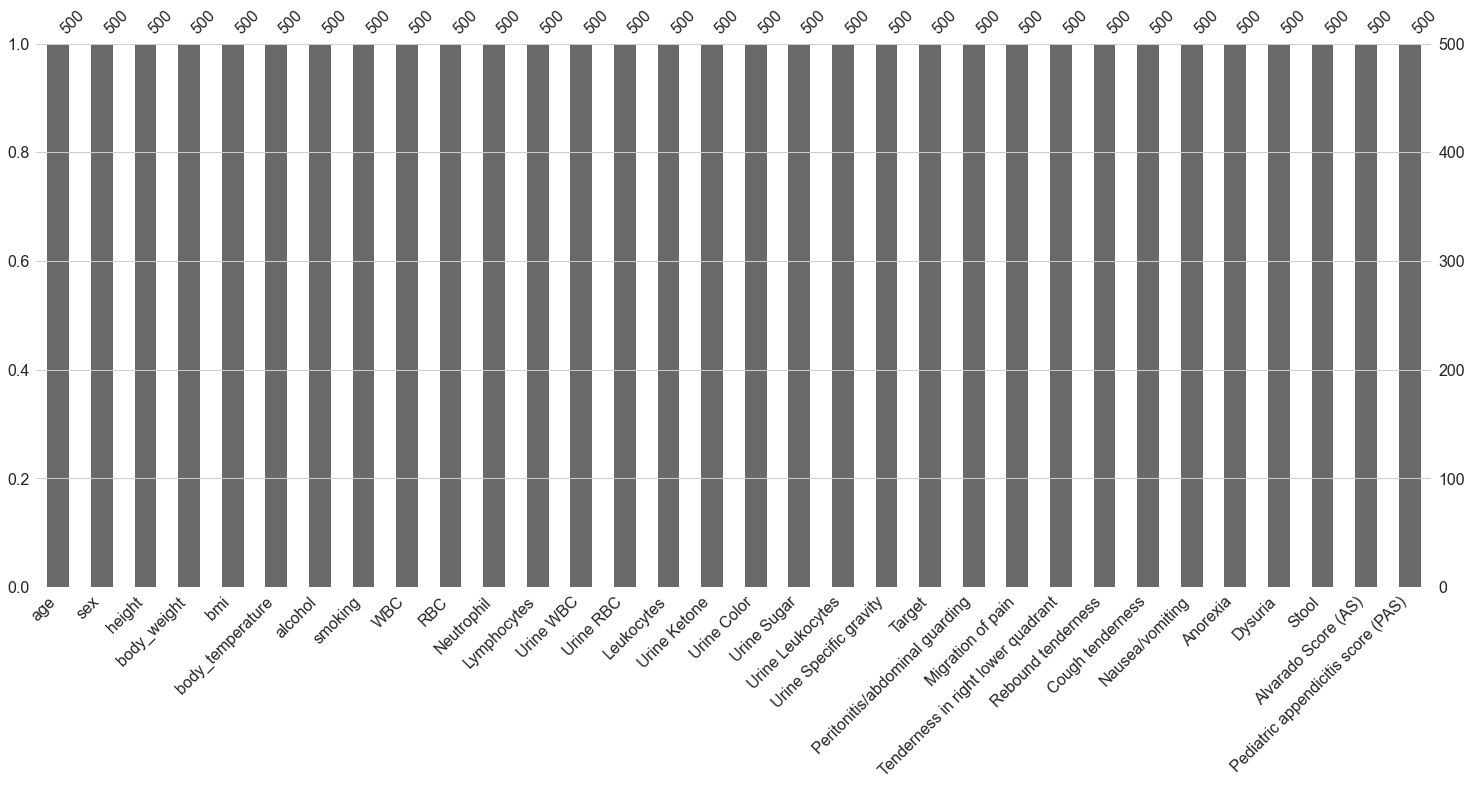

In [31]:
msno.bar(df_prep)

In [32]:
df_prep.describe().T.round(2)

count    mean    std     min     25%  \
age                                 500.0   22.90   9.96    0.00   16.00   
sex                                 500.0    0.50   0.50    0.00    0.00   
height                              500.0  158.19  12.42  128.00  152.00   
body_weight                         500.0   59.34  13.47   31.00   49.23   
bmi                                 500.0   23.04   5.21   11.85   19.14   
body_temperature                    500.0   36.96   0.79   35.10   36.50   
alcohol                             500.0    0.72   0.45    0.00    0.00   
smoking                             500.0    0.71   0.45    0.00    0.00   
WBC                                 500.0   12.04   3.93    3.10    9.00   
RBC                                 500.0    5.01   0.73    1.00    4.65   
Neutrophil                          500.0   71.55  11.58   18.00   64.56   
Lymphocytes                         500.0   21.28  10.00    3.00   13.95   
Urine WBC                           500.0    1.36   0.61    1.00    1.00   
Urine RBC                           500.0    1.16   0.40    1.00    1.00   
Leukocytes                          500.0    1.07   0.23    1.00    1.00   
Urine Ketone                        500.0    1.12   0.33    1.00    1.00   
Urine Color                         500.0    3.34   0.73    2.00    3.00   
Urine Sugar                         500.0    1.06   0.25    1.00    1.00   
Urine Leukocytes                    500.0    2.62   0.91    1.00    2.00   
Urine Specific gravity              500.0    1.02   0.01    1.00    1.02   
Target                              500.0    0.60   0.49    0.00    0.00   
Peritonitis/abdominal guarding      500.0    1.48   0.55    1.00    1.00   
Migration of pain                   500.0    1.82   0.39    1.00    2.00   
Tenderness in right lower quadrant  500.0    1.38   0.48    1.00    1.00   
Rebound tenderness                  500.0    1.48   0.50    1.00    1.00   
Cough tenderness                    500.0    1.86   0.35    1.00    2.00   
Nausea/vomiting                     500.0    1.99   0.09    1.00    2.00   
Anorexia                            500.0    1.73   0.44    1.00    1.00   
Dysuria                             500.0    1.68   0.47    1.00    1.00   
Stool                               500.0    1.73   0.65    1.00    1.00   
Alvarado Score (AS)                 500.0    6.07   2.28    2.00    4.00   
Pediatric appendicitis score (PAS)  500.0    6.64   1.82    2.00    5.00   

                                       50%     75%     max  
age                                  23.00   31.00   40.00  
sex                                   0.50    1.00    1.00  
height                              160.00  167.00  189.00  
body_weight                          57.10   67.00  102.00  
bmi                                  22.48   25.86   39.68  
body_temperature                     36.80   37.20   40.00  
alcohol                               1.00    1.00    1.00  
smoking                               1.00    1.00    1.00  
WBC                                  12.07   14.40   28.01  
RBC                                   5.07    5.44    7.95  
Neutrophil                           72.75   80.28   95.00  
Lymphocytes                          20.37   26.88   77.00  
Urine WBC                             1.00    2.00    3.00  
Urine RBC                             1.00    1.00    3.00  
Leukocytes                            1.00    1.00    3.00  
Urine Ketone                          1.00    1.00    3.00  
Urine Color                           3.00    4.00    7.00  
Urine Sugar                           1.00    1.00    4.00  
Urine Leukocytes                      3.00    3.00    4.00  
Urine Specific gravity                1.02    1.02    1.04  
Target                                1.00    1.00    1.00  
Peritonitis/abdominal guarding        1.00    2.00    3.00  
Migration of pain                     2.00    2.00    2.00  
Tenderness in right lower quadrant    1.00    2.00    2.00  
Re

## Function for Modeling
**Obj**: Easy to Train and Easy to use

In [33]:
def modeling(models, X_train, X_test, y_train, y_test):
    l_performances = []

    for name, model in models:
        start_time = time.time()
        model.fit(X_train, y_train)
        for subset, subset_name, y_true in [(X_train, 'Train', y_train),
                                            (X_test, 'Test', y_test)]:
            y_pred = model.predict(subset)
            # Calculate ROC curve and AUC score
            fpr, tpr, thresholds = roc_curve(y_true, y_pred)
            auc_score = roc_auc_score(y_true, y_pred)
            # Classification Report
            report = classification_report(y_true, y_pred, output_dict=True)
            report_dict = json.loads(json.dumps(report))

            # Extract precision and recall from report_dict
            precision = report_dict['weighted avg']['precision']
            recall = report_dict['weighted avg']['recall']
            accuracy = report_dict['accuracy']

            # Confusion Matrix
            cm = confusion_matrix(y_true, y_pred)
            TP = cm[0][0]
            FP = cm[0][1]
            FN = cm[1][0]
            TN = cm[1][1]
            runtime = format(round((time.time() - start_time)/60, 2))
            # Dict
            my_dict = {'Model': name, 'Runtime': runtime, 'Performance': subset_name,
                       'AUC': auc_score, 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
                       'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

            l_performances.append(my_dict)

    performances = pd.DataFrame(l_performances)
    return performances

## Split X, Y

In [34]:
X = df_prep.drop('Target', axis=1)
y = df_prep['Target']

In [35]:
X

age  sex      height  body_weight        bmi  body_temperature  alcohol  \
0    12.0  0.0  154.000000         39.0  25.749667         36.600000      1.0   
1    37.0  1.0  163.333333         59.0  27.255333         36.500000      1.0   
2    28.0  1.0  173.666667         63.0  25.467333         37.100000      1.0   
3    36.0  1.0  161.000000         43.0  16.589000         36.466667      1.0   
4    19.0  1.0  165.000000         46.0  16.896000         37.100000      1.0   
..    ...  ...         ...          ...        ...               ...      ...   
495  25.0  1.0  177.000000         69.0  36.707000         39.700000      0.0   
496  30.0  0.0  155.000000         55.0  22.893000         37.000000      1.0   
497  26.0  0.0  155.000000         64.4  26.805000         37.300000      1.0   
498  19.0  1.0  154.333333         74.0  20.499000         36.800000      0.0   
499  39.0  0.0  160.000000         74.0  28.906000         37.000000      0.0   

     smoking        WBC       RBC  ...  Migration of pain  \
0        1.0  15.636667  5.423333  ...                  2   
1        1.0   8.550000  5.000000  ...                  2   
2        1.0  14.853333  5.760000  ...                  2   
3        1.0  11.120000  4.690000  ...                  2   
4        1.0  13.530000  4.680000  ...                  2   
..       ...        ...       ...  ...                ...   
495      0.0  16.830000  5.200000  ...                  1   
496      1.0  13.873333  5.630000  ...                  2   
497      0.0   9.866667  5.143333  ...                  1   
498      0.0  11.400000  4.790000  ...                  2   
499      1.0   8.000000  4.250000  ...                  1   

     Tenderness in right lower quadrant  Rebound tenderness  Cough tenderness  \
0                                     1                   1                 2   
1                                     1                   1                 2   
2                                     2                   2                 1   
3                                     1                   1                 2   
4                                     2                   2                 2   
..                                  ...                 ...               ...   
495                                   1                   1                 2   
496                                   1                   1                 2   
497                                   1                   2                 1   
498                                   1                   1                 2   
499                                   1                   1                 2   

     Nausea/vomiting  Anorexia  Dysuria  Stool  Alvarado Score (AS)  \
0                  2         2        1      2                    6   
1                  2         2        2      2                    3   
2                  2         2        1      2                    9   
3                  2         2        2      2                    5   
4                  2         2        2      2                    9   
..               ...       ...      ...    ...                  ...   
495                2         1        1      2                    6   
496                2         2        2      2                    6   
497                2         2        2      1                    4   
498                2         2        1      1                    5   
499                2         2        1      3                    2   

     Pediatric appendicitis score (PAS)  
0                                     7  
1                                     5  
2                                     9  
3                                     6  
4                                     9  
..                                  ...  
495                                   7  
496                                   7  
497                                   4  
498                                   6  
499         

In [36]:
y

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
495    0.0
496    0.0
497    0.0
498    0.0
499    0.0
Name: Target, Length: 500, dtype: float64

## Problem: Class Imbalance

<AxesSubplot: title={'center': 'Count of the target\n0 = No disease, 1 = Disease'}, xlabel='Target', ylabel='count'>

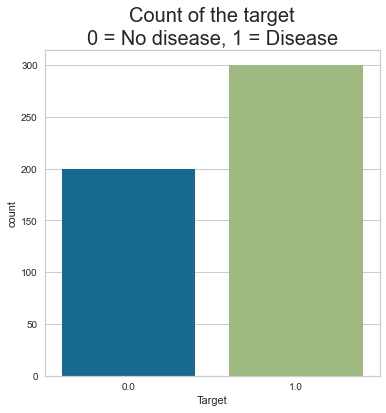

In [37]:
# Dataset with Class Imbalance
plt.figure(figsize=(6, 6))
plt.title('Count of the target\n0 = No disease, 1 = Disease', size=20)
sns.countplot(x="Target", data=df_prep)

## SMOTE 
| **Concept** | **Objective** | **Problem** | **Solve** |
| --- | --- | --- | --- |
| SMOTE (Synthetic Minority `Over-sampling` Technique) | To address `class imbalance` in machine learning datasets by increasing the representation of the minority class through synthetic samples | Class imbalance can lead to biased models with poor performance on the minority class | Generate synthetic samples by interpolating between feature vectors of minority class instances |
| **Pros** | **Cons** | **Outcome** |  |
| `Balances` `class` distribution and `improves` model `performance` / Reduces bias towards majority class / Preserves the original information of minority class | May introduce synthetic samples that are similar to existing ones, leading to overfitting / Computationally expensive for large datasets | Improved classification performance on the minority class by creating a more balanced dataset, leading to better model generalization and increased accuracy |  |


### Library 

In [38]:
from imblearn.over_sampling import SMOTE

In [39]:
oversample = SMOTE(random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X, y)

### Result 

In [40]:
y.value_counts()

1.0    300
0.0    200
Name: Target, dtype: int64

In [41]:
y_resampled.value_counts()

1.0    300
0.0    300
Name: Target, dtype: int64

### After performing SMOTE oversampling, Will the correlation change?
#### <u>Prove</u>

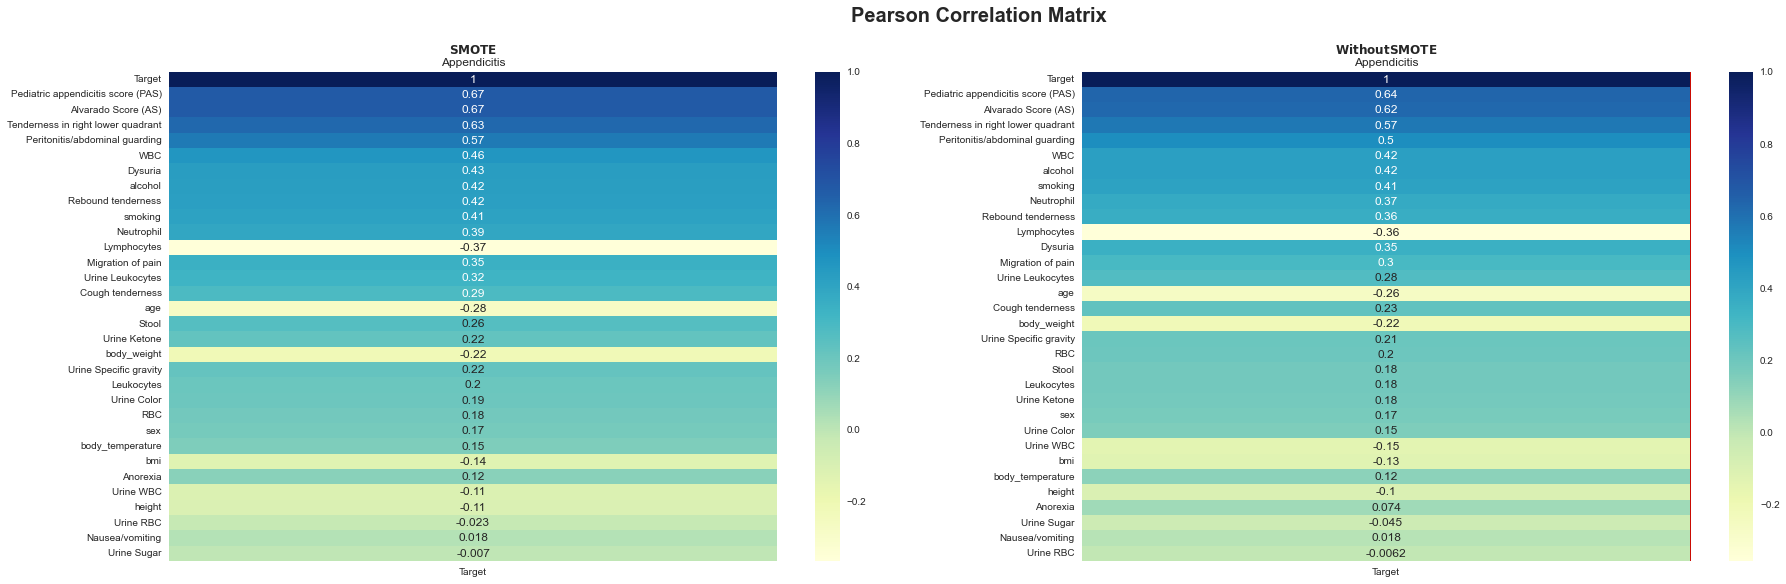

In [42]:
compare_dict ={'SMOTE':pd.concat([X_resampled, y_resampled], axis=1), 'Without SMOTE':pd.concat([X, y], axis=1)}

fig, axes = plt.subplots(1, 2, figsize=(30, 9))
fig.suptitle('Pearson Correlation Matrix', fontsize=20, fontweight='bold')

index = 0
for name, df in compare_dict.items():
    corr_matrix = df.corr()
    # Df section
    target_corr = corr_matrix['Target']
    other_corr = corr_matrix.drop('Target')['Target']
    corr_df = pd.DataFrame({'Target': target_corr})
    corr_df = corr_df.reindex(
        corr_df['Target'].abs().sort_values(ascending=False).index)
    # Graph Section

    axes[index].set_title(r'$\bf{' + name + '}$' +
                          f'\nAppendicitis')
    sns.heatmap(corr_df, cmap="YlGnBu", annot=True, ax=axes[index])
    plt.vlines(x=1, ymin=0, ymax=len(corr_df), colors='r', linewidth=2)
    index += 1
plt.show()

<u>**Answer**</u> No
after SMOTE the correlation remain relatively unchanged.

<u>**means**</u> after SMOTE synthetic samples are similar to existing minority class instances

## Splitting and Fitting
### Hold-out

how it works:

Split data into 3 segments
1.   1st segment called "Train" is used for fitting model
2.   2rd segment called "Test or held-out" is used as an unseen data for model evaluation
3.   3nd segment called "Val or Dev" is used as an Test to confirm 
### Ratio (80:20)
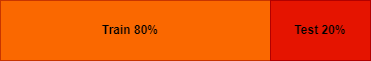

In [43]:
# Train : Test : Valid = 80:20

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    random_state=42,
                                                    test_size=0.2)

In [44]:
# This is how to split into 3 segments
# Train : Test : Valid = 80:20
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
#                                                     random_state=42,
#                                                     test_size=0.2)
# Train : Test : Valid = 80:10:10
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42,
#                                                 test_size=0.5)

In [45]:
len(X_train)

480

In [46]:
len(X_test)

120

## Training SMOTE vs Without SMOTE

### SMOTE

In [47]:
%%time
rf = RandomForestClassifier()
lr = LogisticRegression()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
gnb = GaussianNB()
lgbmc = LGBMClassifier()
xgbc = XGBClassifier()
knc = KNeighborsClassifier(3)
dtc = DecisionTreeClassifier()
dummyc = DummyClassifier(strategy='most_frequent', random_state=0)

models = [('Random Forest', rf), ('Logistic Regression', lr),
          ('Gradient Boosting Classifier', gbc),
          ('AdaBoostClassifier', abc), ('GaussianNB', gnb), 
          ('LGBMClassifier', lgbmc), ('XGBClassifier', xgbc), 
          ('KNeighborsClassifier', knc), ('DecisionTreeClassifier', dtc), 
          ('DummyClassifier_most_frequent', dummyc)]
          
smote_performances = modeling(
    models, X_train, X_test, y_train, y_test)
smote_performances

CPU times: total: 3.8 s
Wall time: 1.16 s


Model Runtime Performance       AUC   TP  FP   FN  \
0                   Random Forest     0.0       Train  1.000000  242   0    0   
1                   Random Forest     0.0        Test  0.908509   53   5    6   
2             Logistic Regression     0.0       Train  0.918692  224  18   21   
3             Logistic Regression     0.0        Test  0.908509   53   5    6   
4    Gradient Boosting Classifier     0.0       Train  0.995868  240   2    0   
5    Gradient Boosting Classifier     0.0        Test  0.917130   54   4    6   
6              AdaBoostClassifier     0.0       Train  0.977030  238   4    7   
7              AdaBoostClassifier     0.0        Test  0.901001   54   4    8   
8                      GaussianNB     0.0       Train  0.878811  223  19   39   
9                      GaussianNB     0.0        Test  0.892937   54   4    9   
10                 LGBMClassifier     0.0       Train  0.997934  241   1    0   
11                 LGBMClassifier     0.0        Test  0.932703   53   5    3   
12                  XGBClassifier     0.0       Train  1.000000  242   0    0   
13                  XGBClassifier     0.0        Test  0.924638   53   5    4   
14           KNeighborsClassifier     0.0       Train  0.906018  226  16   29   
15           KNeighborsClassifier     0.0        Test  0.760011   47  11   18   
16         DecisionTreeClassifier     0.0       Train  1.000000  242   0    0   
17         DecisionTreeClassifier     0.0        Test  0.907397   51   7    4   
18  DummyClassifier_most_frequent     0.0       Train  0.500000  242   0  238   
19  DummyClassifier_most_frequent     0.0        Test  0.500000   58   0   62   

     TN  Precision    Recall  Accuracy  
0   238   1.000000  1.000000  1.000000  
1    56   0.908498  0.908333  0.908333  
2   217   0.918807  0.918750  0.918750  
3    56   0.908498  0.908333  0.908333  
4   238   0.995868  0.995833  0.995833  
5    56   0.917222  0.916667  0.916667  
6   231   0.977156  0.977083  0.977083  
7    54   0.902002  0.900000  0.900000  
8   199   0.881737  0.879167  0.879167  
9    53   0.894695  0.891667  0.891667  
10  238   0.997925  0.997917  0.997917  
11   59   0.933743  0.933333  0.933333  
12  238   1.000000  1.000000  1.000000  
13   58   0.925077  0.925000  0.925000  
14  209   0.907404  0.906250  0.906250  
15   44   0.762821  0.758333  0.758333  
16  238   1.000000  1.000000  1.000000  
17   58   0.909207  0.908333  0.908333  
18    0   0.254184  0.504167  0.504167  
19    0   0.233611  0.483333  0.483333

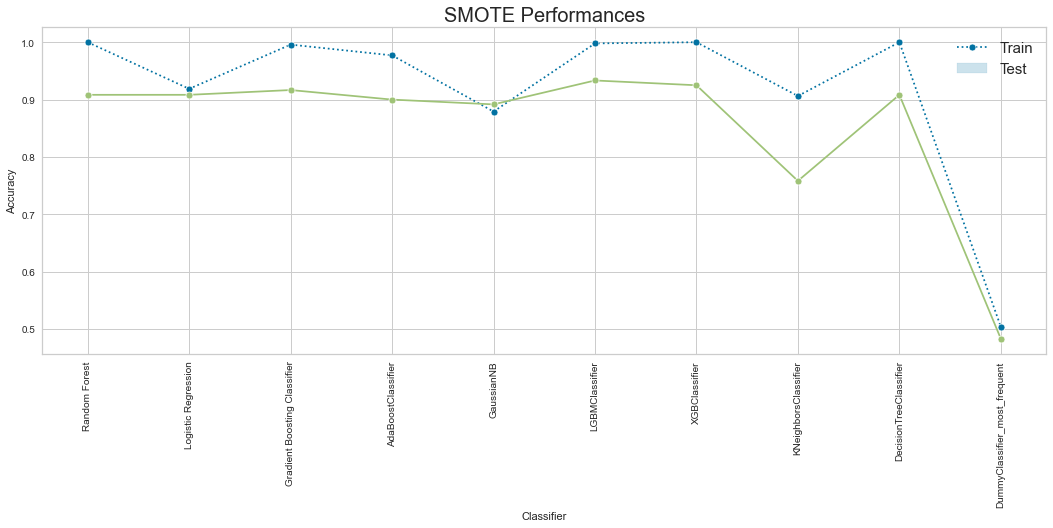

In [48]:
# Set the figure size
plt.figure(figsize=(18, 6))  # Adjust the width and height as needed

# Train
train_ = smote_performances.loc[smote_performances['Performance'] == 'Train'][[
    'Model', 'Accuracy']]

# Test
test_ = smote_performances.loc[smote_performances['Performance'] == 'Test'][[
    'Model', 'Accuracy']]

# Calculate mean and standard deviation
train_mean = np.mean(train_['Accuracy'])
train_std = np.std(train_['Accuracy'])

test_mean = np.mean(test_['Accuracy'])
test_std = np.std(test_['Accuracy'])

# Train Line
sns.lineplot(data=train_, x='Model', y='Accuracy',
             marker='o', linestyle='dotted')

# Test Line
sns.lineplot(data=test_, x='Model', y='Accuracy', marker='o')

# Set x-axis labels rotation
plt.xticks(rotation=90)

# Add labels and title
plt.legend(['Train', 'Test'], loc='best', fontsize=15)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('SMOTE Performances', fontsize=20)

# Show the plot
plt.show()


### Without SMOTE

In [49]:
# Train : Test : Valid = 80:20

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

In [50]:
%%time
rf = RandomForestClassifier()
lr = LogisticRegression()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
gnb = GaussianNB()
lgbmc = LGBMClassifier()
xgbc = XGBClassifier()
knc = KNeighborsClassifier(3)
dtc = DecisionTreeClassifier()
dummyc = DummyClassifier(strategy='most_frequent', random_state=0)

models = [('Random Forest', rf), ('Logistic Regression', lr),
          ('Gradient Boosting Classifier', gbc),
          ('AdaBoostClassifier', abc), ('GaussianNB', gnb), 
          ('LGBMClassifier', lgbmc), ('XGBClassifier', xgbc), 
          ('KNeighborsClassifier', knc), ('DecisionTreeClassifier', dtc), 
          ('DummyClassifier_most_frequent', dummyc)]
without_smote_performances = modeling(
    models, X_train, X_test, y_train, y_test)
without_smote_performances


CPU times: total: 3.22 s
Wall time: 902 ms


Model Runtime Performance       AUC   TP   FP  FN  \
0                   Random Forest     0.0       Train  1.000000  152    0   0   
1                   Random Forest     0.0        Test  0.939103   44    4   2   
2             Logistic Regression     0.0       Train  0.888582  131   21  21   
3             Logistic Regression     0.0        Test  0.928686   43    5   2   
4    Gradient Boosting Classifier     0.0       Train  0.993421  150    2   0   
5    Gradient Boosting Classifier     0.0        Test  0.928686   43    5   2   
6              AdaBoostClassifier     0.0       Train  0.968166  146    6   6   
7              AdaBoostClassifier     0.0        Test  0.876603   38   10   2   
8                      GaussianNB     0.0       Train  0.867466  135   17  38   
9                      GaussianNB     0.0        Test  0.858974   40    8   6   
10                 LGBMClassifier     0.0       Train  1.000000  152    0   0   
11                 LGBMClassifier     0.0        Test  0.907853   41    7   2   
12                  XGBClassifier     0.0       Train  1.000000  152    0   0   
13                  XGBClassifier     0.0        Test  0.907853   41    7   2   
14           KNeighborsClassifier     0.0       Train  0.814728  111   41  25   
15           KNeighborsClassifier     0.0        Test  0.693109   25   23   7   
16         DecisionTreeClassifier     0.0       Train  1.000000  152    0   0   
17         DecisionTreeClassifier     0.0        Test  0.814103   32   16   2   
18  DummyClassifier_most_frequent     0.0       Train  0.500000    0  152   0   
19  DummyClassifier_most_frequent     0.0        Test  0.500000    0   48   0   

     TN  Precision  Recall  Accuracy  
0   248   1.000000  1.0000    1.0000  
1    50   0.940612  0.9400    0.9400  
2   227   0.895000  0.8950    0.8950  
3    50   0.931394  0.9300    0.9300  
4   248   0.995040  0.9950    0.9950  
5    50   0.931394  0.9300    0.9300  
6   242   0.970000  0.9700    0.9700  
7    50   0.889333  0.8800    0.8800  
8   210   0.870100  0.8625    0.8625  
9    46   0.860354  0.8600    0.8600  
10  248   1.000000  1.0000    1.0000  
11   50   0.913815  0.9100    0.9100  
12  248   1.000000  1.0000    1.0000  
13   50   0.913815  0.9100    0.9100  
14  223   0.833859  0.8350    0.8350  
15   45   0.719118  0.7000    0.7000  
16  248   1.000000  1.0000    1.0000  
17   50   0.845704  0.8200    0.8200  
18  248   0.384400  0.6200    0.6200  
19   52   0.270400  0.5200    0.5200

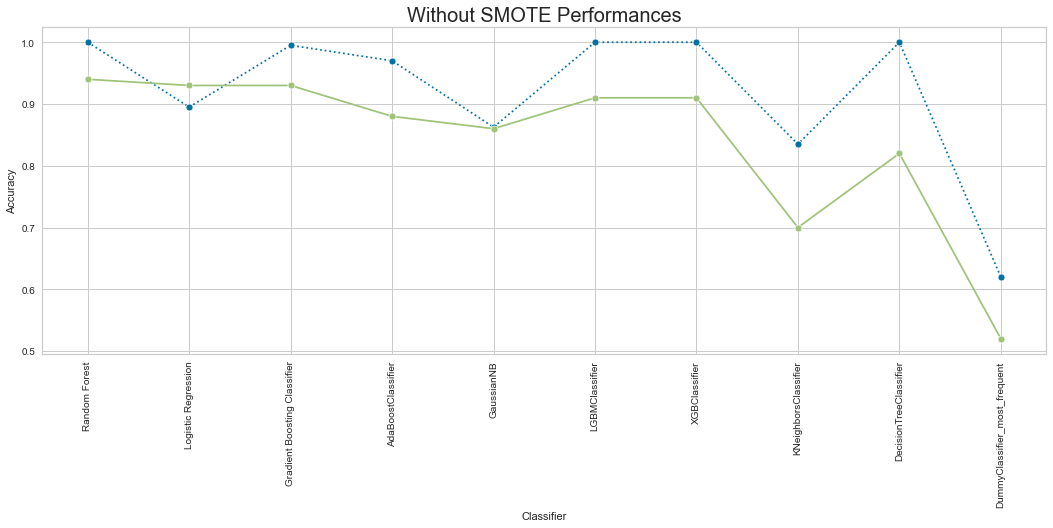

In [51]:
# Set the figure size
plt.figure(figsize=(18, 6))  # Adjust the width and height as needed

# Train
train_ = without_smote_performances.loc[without_smote_performances['Performance'] == 'Train'][[
    'Model', 'Accuracy']]

# Test
test_ = without_smote_performances.loc[without_smote_performances['Performance'] == 'Test'][[
    'Model', 'Accuracy']]

# Calculate mean and standard deviation
train_mean = np.mean(train_['Accuracy'])
train_std = np.std(train_['Accuracy'])

test_mean = np.mean(test_['Accuracy'])
test_std = np.std(test_['Accuracy'])

# Train Line
train_line = sns.lineplot(data=train_, x='Model', y='Accuracy',
             marker='o', linestyle='dotted')

# Test Line
test_line = sns.lineplot(data=test_, x='Model', y='Accuracy', marker='o')

# Set x-axis labels rotation
plt.xticks(rotation=90)

# Add labels and title
plt.legend([train_line, test_line], ['Train', 'Test'], loc='best', fontsize=15)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Without SMOTE Performances', fontsize=20)

# Show the plot
plt.show()


### Comparison

In [52]:
smote_performances.loc[smote_performances['Performance']
                       == 'Test'].sort_values(by='Accuracy',ascending=False)

Model Runtime Performance       AUC  TP  FP  FN  \
11                 LGBMClassifier     0.0        Test  0.932703  53   5   3   
13                  XGBClassifier     0.0        Test  0.924638  53   5   4   
5    Gradient Boosting Classifier     0.0        Test  0.917130  54   4   6   
1                   Random Forest     0.0        Test  0.908509  53   5   6   
3             Logistic Regression     0.0        Test  0.908509  53   5   6   
17         DecisionTreeClassifier     0.0        Test  0.907397  51   7   4   
7              AdaBoostClassifier     0.0        Test  0.901001  54   4   8   
9                      GaussianNB     0.0        Test  0.892937  54   4   9   
15           KNeighborsClassifier     0.0        Test  0.760011  47  11  18   
19  DummyClassifier_most_frequent     0.0        Test  0.500000  58   0  62   

    TN  Precision    Recall  Accuracy  
11  59   0.933743  0.933333  0.933333  
13  58   0.925077  0.925000  0.925000  
5   56   0.917222  0.916667  0.916667  
1   56   0.908498  0.908333  0.908333  
3   56   0.908498  0.908333  0.908333  
17  58   0.909207  0.908333  0.908333  
7   54   0.902002  0.900000  0.900000  
9   53   0.894695  0.891667  0.891667  
15  44   0.762821  0.758333  0.758333  
19   0   0.233611  0.483333  0.483333

In [53]:
without_smote_performances.loc[without_smote_performances['Performance']
                       == 'Test'].sort_values(by='Accuracy',ascending=False)

Model Runtime Performance       AUC  TP  FP  FN  \
1                   Random Forest     0.0        Test  0.939103  44   4   2   
3             Logistic Regression     0.0        Test  0.928686  43   5   2   
5    Gradient Boosting Classifier     0.0        Test  0.928686  43   5   2   
11                 LGBMClassifier     0.0        Test  0.907853  41   7   2   
13                  XGBClassifier     0.0        Test  0.907853  41   7   2   
7              AdaBoostClassifier     0.0        Test  0.876603  38  10   2   
9                      GaussianNB     0.0        Test  0.858974  40   8   6   
17         DecisionTreeClassifier     0.0        Test  0.814103  32  16   2   
15           KNeighborsClassifier     0.0        Test  0.693109  25  23   7   
19  DummyClassifier_most_frequent     0.0        Test  0.500000   0  48   0   

    TN  Precision  Recall  Accuracy  
1   50   0.940612    0.94      0.94  
3   50   0.931394    0.93      0.93  
5   50   0.931394    0.93      0.93  
11  50   0.913815    0.91      0.91  
13  50   0.913815    0.91      0.91  
7   50   0.889333    0.88      0.88  
9   46   0.860354    0.86      0.86  
17  50   0.845704    0.82      0.82  
15  45   0.719118    0.70      0.70  
19  52   0.270400    0.52      0.52

### Considering SMOTE
<u>**Anwser**</u> Some model's Accuracy increased 1 to 5% and some Accuracy is decreased, But correctness of some model's prediction (TP,FP) is obviously better

## Learning curve
### What is learning curve?
**Learning curves**: Plot the training and validation accuracy as a function of the number of training samples. 
- **`High Bias (Underfitting)`**: If the `training` and `validation` scores are `both low` and `close together`, 
    - it suggests that the model is `not able` to `learn` from the data, i.e., underfitting. In this case, adding more training data is unlikely to help, and you may need to consider using a more complex model or adjusting the hyperparameters.

- **`High Variance (Overfitting)`**: If the `training` score is `high` and the `validation` score is `low`, or if the two scores are `far apart`, 
    - it suggests that the model is **`overfitting`**, i.e., 
    - it has learned to fit the `training` data `too well` and is `not` able to `generalize` to new data. In this case, adding more training data may help, or you may need to consider using a simpler model or regularization techniques.

- **`Good Fit`**: If both the `training` and `validation` scores are `high` and `close together`, 
    - it suggests that the model is `performing well` and is `able` to `generalize` to new data.

**Obj**: 
- Help to `identify` **`underfitting`** or **`overfitting`** and guide the selection of the optimal model complexity.
- Know the minimum data is needed
- Help to decide whether we need to gather more data or not
- **Generalization ability**: model can perform well on unseen or new data.
- **Identifying Good Learners**: The number of **training samples** required for a classifier to achieve good performance
- **Detecting Overfitting**: Training  > Test performance = suggests overfitting

In [54]:
def viz_learning_curve(model_name, model, X_train, y_train):
    fig = plt.figure(figsize=(14, 7))

    train_sizes, train_scores, valid_scores = learning_curve(model,
                                                             X_train,
                                                             y_train,
                                                             train_sizes=np.linspace(
                                                                 0.1, 1.0, 10),
                                                             cv=10)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    # Train Line
    plt.plot(train_sizes, train_mean, label='Training accuracy')
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    # Validation Line
    plt.plot(train_sizes, valid_mean, label='Validation accuracy')
    plt.fill_between(train_sizes, valid_mean - valid_std,
                     valid_mean + valid_std, alpha=0.1)
    plt.legend(loc='best', fontsize=15)
    plt.xlabel('Training examples', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.title(f'Learning curves of ' +
              r'$\bf{' + f'{model_name}' + '}$', fontsize=20)
    return plt.show()

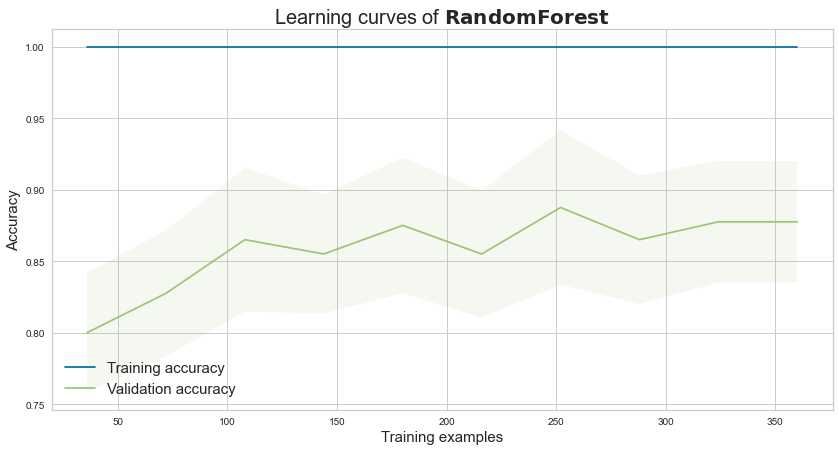

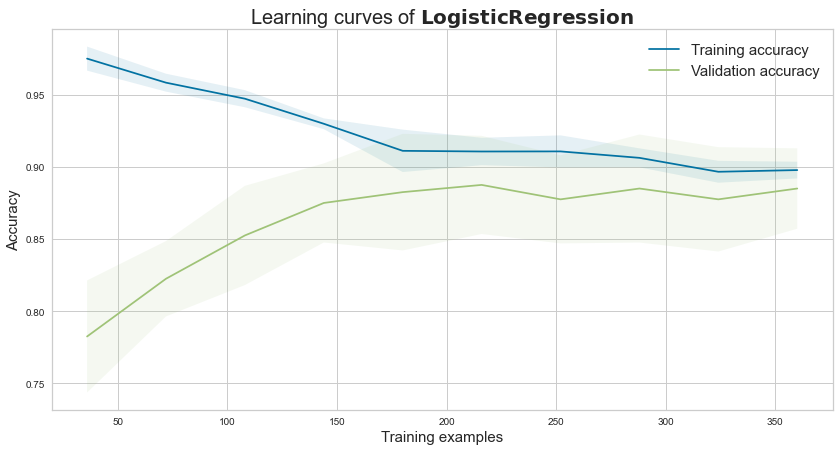

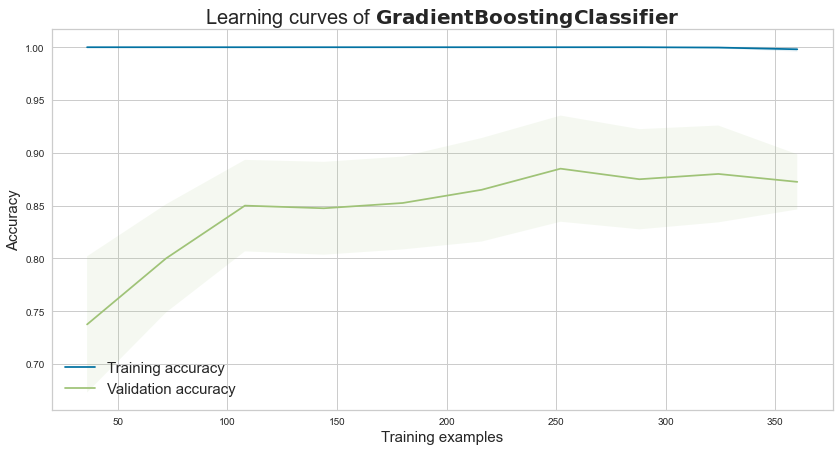

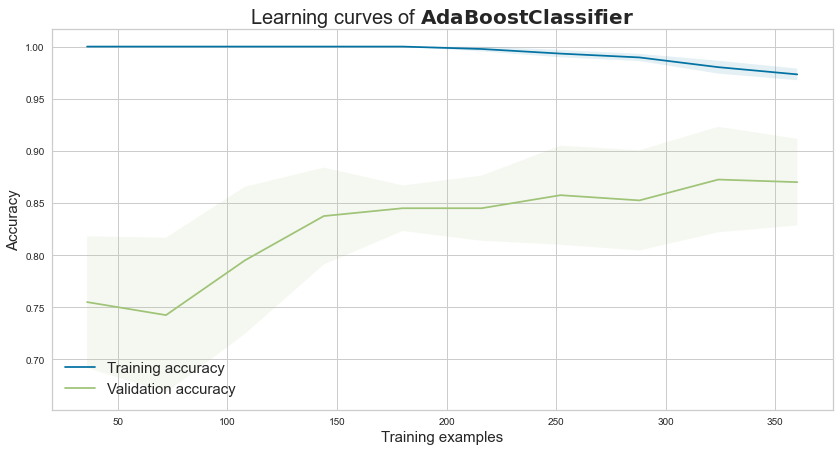

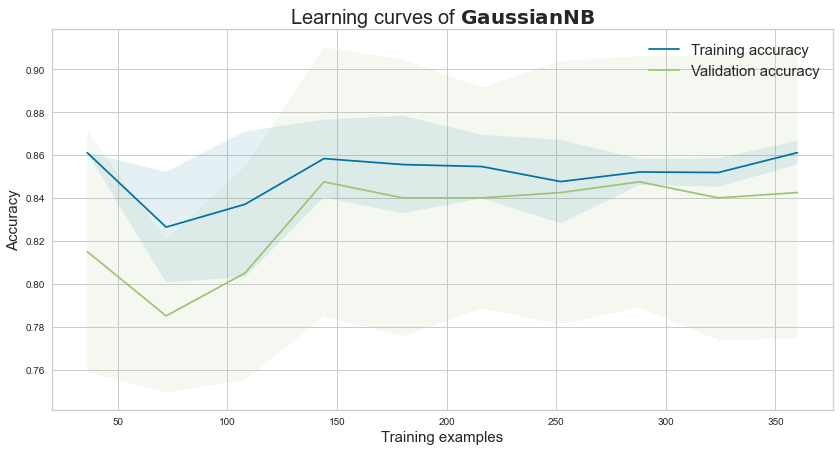

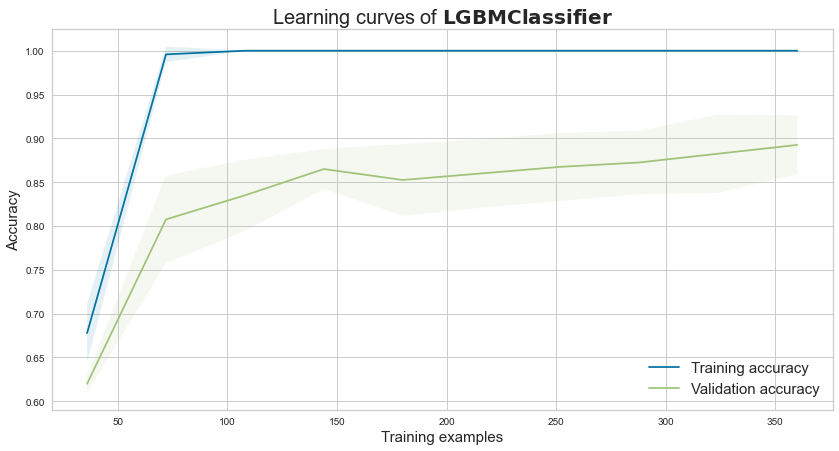

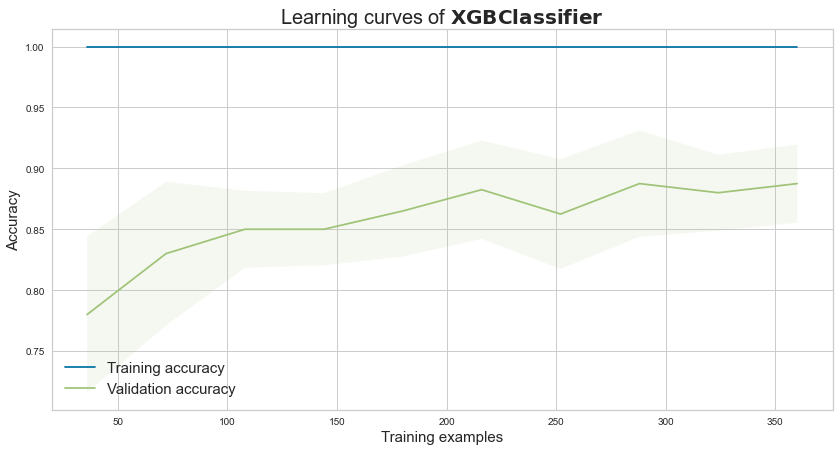

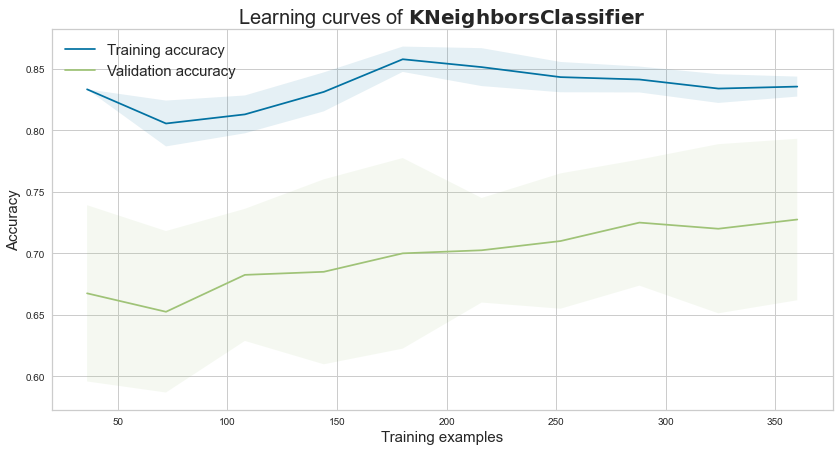

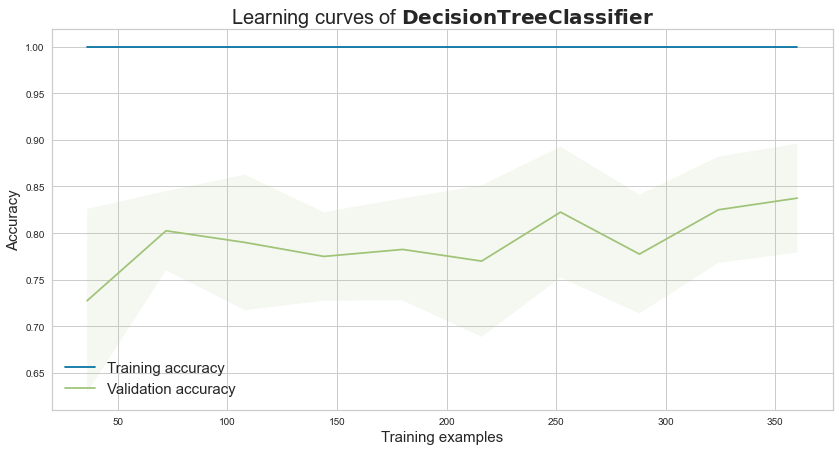

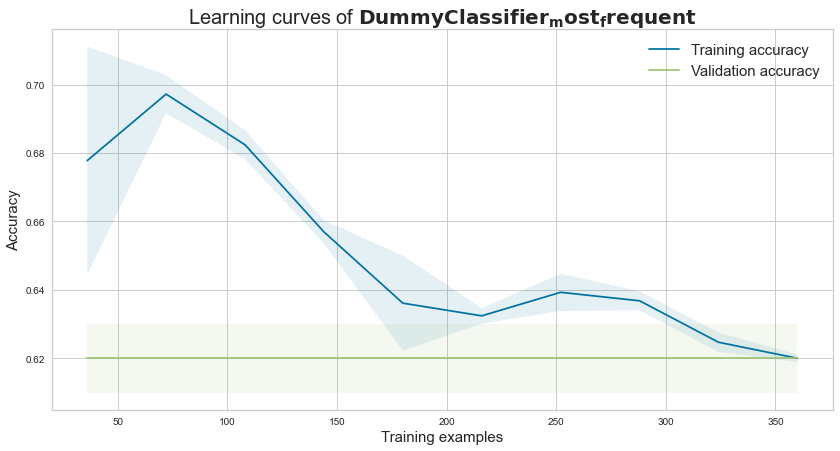

In [55]:
for name, model in models: 
    viz_learning_curve(name,model, X_train, y_train)

In [56]:
# With SMOTE
smote_performances.loc[smote_performances['Performance']
                       == 'Test'].sort_values(by='Accuracy',ascending=False)

Model Runtime Performance       AUC  TP  FP  FN  \
11                 LGBMClassifier     0.0        Test  0.932703  53   5   3   
13                  XGBClassifier     0.0        Test  0.924638  53   5   4   
5    Gradient Boosting Classifier     0.0        Test  0.917130  54   4   6   
1                   Random Forest     0.0        Test  0.908509  53   5   6   
3             Logistic Regression     0.0        Test  0.908509  53   5   6   
17         DecisionTreeClassifier     0.0        Test  0.907397  51   7   4   
7              AdaBoostClassifier     0.0        Test  0.901001  54   4   8   
9                      GaussianNB     0.0        Test  0.892937  54   4   9   
15           KNeighborsClassifier     0.0        Test  0.760011  47  11  18   
19  DummyClassifier_most_frequent     0.0        Test  0.500000  58   0  62   

    TN  Precision    Recall  Accuracy  
11  59   0.933743  0.933333  0.933333  
13  58   0.925077  0.925000  0.925000  
5   56   0.917222  0.916667  0.916667  
1   56   0.908498  0.908333  0.908333  
3   56   0.908498  0.908333  0.908333  
17  58   0.909207  0.908333  0.908333  
7   54   0.902002  0.900000  0.900000  
9   53   0.894695  0.891667  0.891667  
15  44   0.762821  0.758333  0.758333  
19   0   0.233611  0.483333  0.483333

### Overfitting/underfitting Learning curves
Read more: https://articles.bnomial.com/overfitting-underfitting-learning-curves

### Comparing Classifiers
<u>**Answer**</u> Among the classifiers evaluated, **Logistic Regression** demonstrates the best performance. However, there is a slight gap between the accuracy of the model. This **suggests** that **adding** more **training samples** can further enhance the model's performance and reduce the gap.

**Overall**, the **Logistic Regression** model shows good generalization ability, indicating its effectiveness in making accurate predictions on unseen data.

In [57]:
# SMOTE (X_resampled, y_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    random_state=42,
                                                    test_size=0.2)

## Hyperparameters Tuning

### **1. RandomForestClassifier**

#### Hyperparameters

**1. `n_estimators`**:

- **Objective**: Number of trees in the forest.
- **Positive Effects**: Increased model complexity, reduced variance, better generalization.
- **Negative Effects**: Longer training time, increased memory usage.
- **Solving/Prevention**: Choose an appropriate number of estimators that provides a good balance between model complexity and training time. Adding more estimators beyond a certain point may not significantly improve the model's performance, so it's important to find the optimal value through experimentation or hyperparameter tuning.

**2. `criterion`**:

- **Objective**: Criterion used to evaluate the quality of a split when building decision trees within the random forest.
- **Positive Effects**: Improved split quality, more effective feature selection.
- **Negative Effects**: None.
- **Solving/Prevention**: Choose an appropriate criterion based on the problem at hand. The default is "gini" for Gini impurity, but you can also use "entropy" for information gain. Experimentation may be required to determine the best choice.

**3. `max_depth`**:

- **Objective**: Maximum depth of the tree.
- **Positive Effects**: Increased model capacity, potentially improved accuracy.
- **Negative Effects**: <u>Overfitting</u>, longer training time, increased complexity.
- **Solving/Prevention**: Limit the maximum depth to control model complexity and <u>prevent overfitting</u>. The optimal value depends on the dataset and can be determined through experimentation or hyperparameter tuning.

**4. `min_samples_split`**:

- **Objective**: Minimum number of samples required to split an internal node.
- **Positive Effects**: Controls <u>overfitting</u>, improves generalization.
- **Negative Effects**: Reduced model capacity.
- **Solving/Prevention**: Increase this value to <u>prevent overfitting</u> and limit unnecessary splits. The optimal value depends on the dataset and can be determined through experimentation or hyperparameter tuning.

**5. `min_samples_leaf`**:

- **Objective**: Minimum number of samples required to be at a leaf node.
- **Positive Effects**: Controls <u>overfitting</u>, improves generalization.
- **Negative Effects**: Reduced model capacity.
- **Solving/Prevention**: Increase this value to <u>prevent overfitting</u> and limit leaf nodes. The optimal value depends on the dataset and can be determined through experimentation or hyperparameter tuning.

**6. `max_features`**:

- **Objective**: Maximum number of features to consider when making a split.
- **Positive Effects**: Controls model complexity, improves generalization.
- **Negative Effects**: Potential loss of important features.
- **Solving/Prevention**: Limit the number of features considered for each split to <u>prevent overfitting</u> and improve generalization. The optimal value depends on the dataset and can be determined through experimentation or hyperparameter tuning.

In [58]:
param_grid_rf = {
    'n_estimators': [1,2,4,8,16,32,64,128],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
    }

In [59]:
rf = RandomForestClassifier()

In [60]:
%%time
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5,
                           return_train_score=True,
                           )
grid_search_rf.fit(X_train, y_train)

CPU times: total: 58.1 s
Wall time: 58.2 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128]},
             return_train_score=True)

In [61]:
print('Random Forest')
print('Best parameters:', grid_search_rf.best_params_)
print('Best score:', grid_search_rf.best_score_)
rf_result = pd.DataFrame(grid_search_rf.cv_results_)

Random Forest
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 8}
Best score: 0.9145833333333332


####  Feature importance from Random Forrest Classifier

In [62]:
rf_best_parm = grid_search_rf.best_estimator_

In [63]:
feature_importances = pd.DataFrame(rf_best_parm.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

importance
Alvarado Score (AS)                   0.139792
Peritonitis/abdominal guarding        0.111084
WBC                                   0.098057
Tenderness in right lower quadrant    0.074825
Pediatric appendicitis score (PAS)    0.072166
Rebound tenderness                    0.061729
smoking                               0.060942
alcohol                               0.056745
Migration of pain                     0.053771
age                                   0.051720

#### Plot trees for a Random Forest 

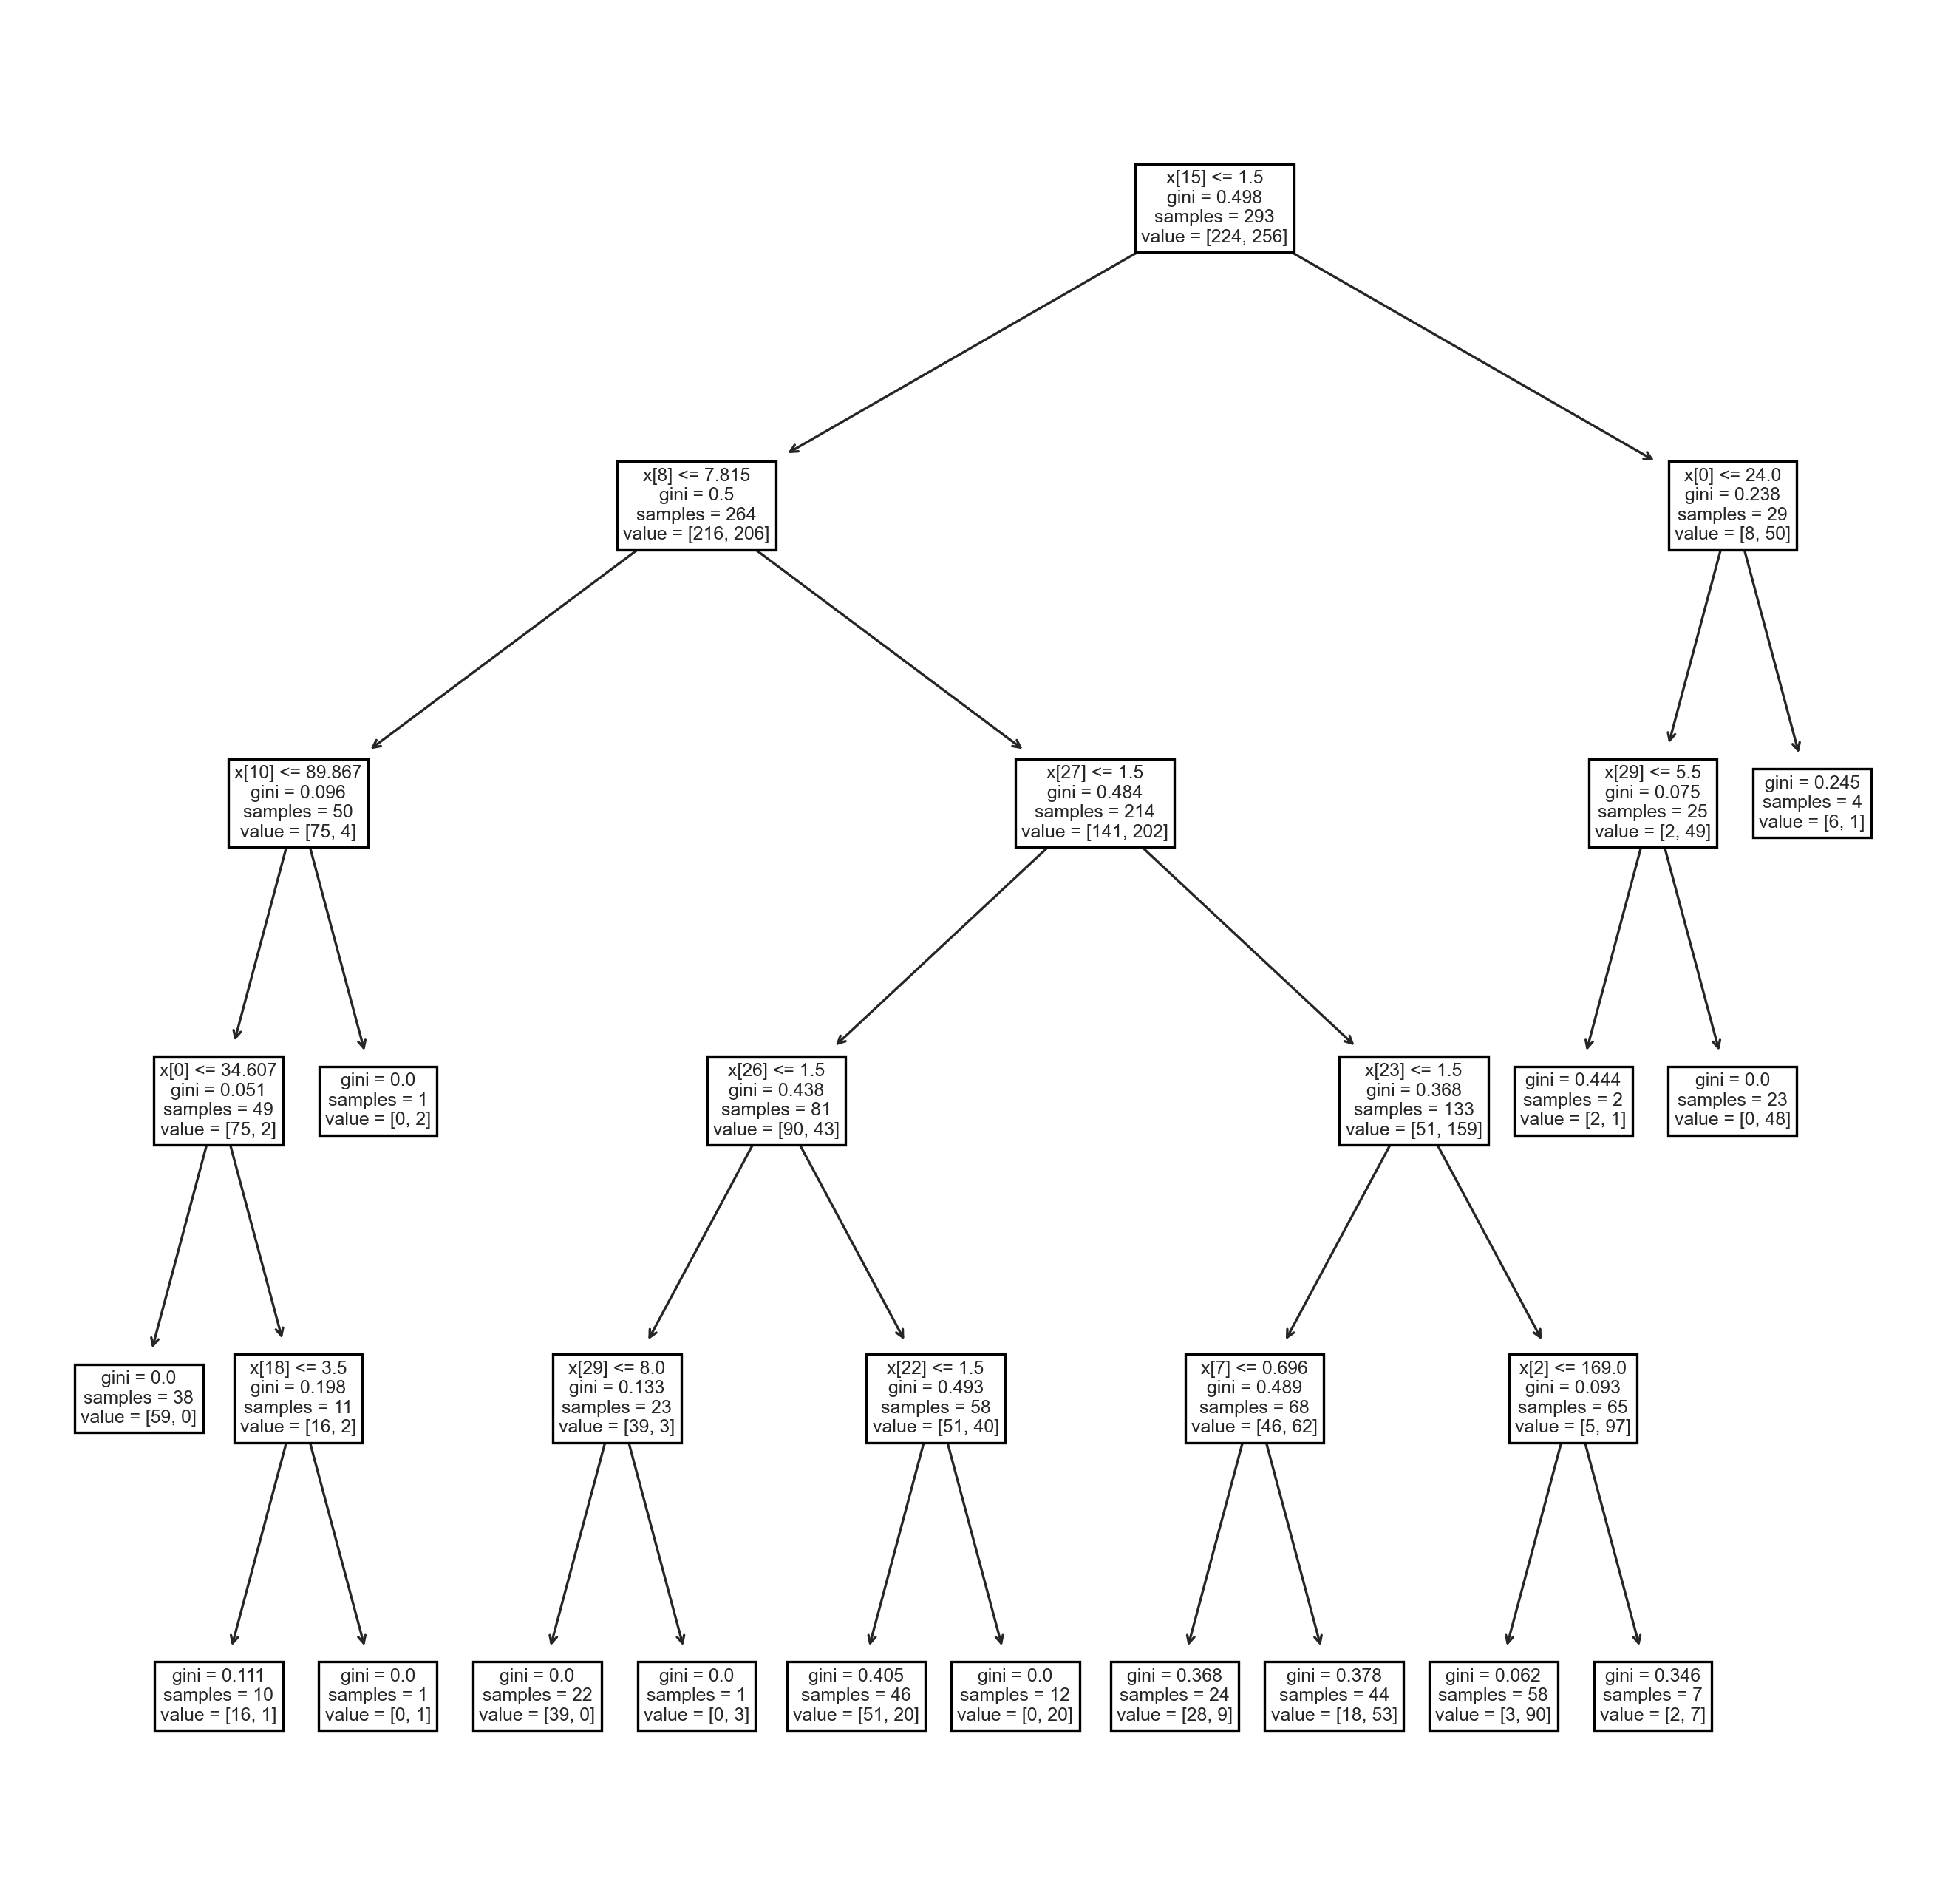

In [64]:
from sklearn import tree

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=800)
tree.plot_tree(rf_best_parm.estimators_[0])
fig.savefig('rf_tree.png')

#### Insight of Tree plot
- **Root Node and Splits**: number of features are used for the splits
- **Node Impurity**: The quality of a split.
- **Leaf Nodes and Predictions**: final outcomes or predictions made by the tree. They show the class labels or values assigned distribution of classes or predicted values.
- **Tree Depth and Complexity**: The depth of the tree, i.e., the maximum number of splits between the root node and any leaf node, provides insights into the model's complexity. A deeper tree may suggest more complex decision boundaries or potential overfitting.

### **2. LogisticRegression**

#### Hyperparameters

**1. `penalty`**:

- **Objective**: Regularization technique to avoid <u>overfitting</u>.
- **Positive Effects**: Helps in reducing <u>overfitting</u>, improves generalization.
- **Negative Effects**: None.
- **Solving/Prevention**: Choose an appropriate penalty type based on the problem at hand. L1 penalty (Lasso regularization) is useful when dealing with a large number of features and feature selection is desired. L2 penalty (Ridge regularization) is effective in controlling the impact of important features. Elasticnet penalty combines both L1 and L2 regularization.

**2. `C`**:

- **Objective**: Controls the degree of regularization applied to the model.
- **Positive Effects**: Helps in preventing <u>overfitting</u>, improves generalization.
- **Negative Effects**: Excessive regularization can lead to underfitting.
- **Solving/Prevention**: Choose an appropriate value for C to balance the trade-off between fitting the training data well and generalizing to new data. Smaller values of C provide stronger regularization, while larger values reduce the regularization strength.

**3. `solver`**:

- **Objective**: Algorithm used to minimize the cost function.
- **Positive Effects**: Helps in finding optimal model parameters.
- **Negative Effects**: None.
- **Solving/Prevention**: Choose an appropriate solver based on the characteristics of the dataset. "newton-cg" is suitable for small datasets, "lbfgs" is efficient for datasets with many features, "liblinear" is suitable for small and large datasets with noise or outliers, and "sag" and "saga" are useful when the number of samples is much larger than the number of features.
    - **newton-cg** for small datasets
    - **lbfgs** for datasets with many features
    - **liblinear** for small and large datasets, and if datasets have a lot of noise or outliers.
    - **'sag'** and **'saga'** when the number of samples is much larger than the number of features.

In [65]:
np.linspace(0.01, 1.0, 10)

array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])

In [66]:
param_grid_lr = {'C': np.linspace(0.01, 1.0, 10),
            'penalty': ['l1', 'l2'],
            'solver': ['lbfgs', 'liblinear', 'saga']}

In [67]:
lr = LogisticRegression()

In [68]:
%%time
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5,
                              return_train_score=True,
                              )

grid_search_lr.fit(X_train, y_train)

CPU times: total: 10.9 s
Wall time: 10.7 s


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             return_train_score=True)

In [69]:
print('Logistic Regression')
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)
lr_result = pd.DataFrame(grid_search_lr.cv_results_)

Logistic Regression
Best parameters: {'C': 0.67, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.90625


### **3. DecisionTreeClassifier**

#### Hyperparameters

1. **criterion**
    - **`Objective`**: Determines the function to measure the **`quality`** of a **`split`**.
        - **"gini"**: Gini impurity measures the degree of impurity or the probability of incorrectly classifying a randomly chosen element.
        - **"entropy"**: Entropy measures the level of disorder or uncertainty in a set of samples. It seeks to maximize the information gain at each split.
2. **splitter**
    - **`Objective`**: Determines the strategy used to choose the split at each node.
        - **"best"**: Selects the best split based on the criterion (gini or entropy).
        - **"random"**: Selects the best random split.
3. **max_depth**
    - **`Objective`**: Specifies the maximum depth of the decision tree.
        - Controls the maximum number of levels in the tree, <u>preventing **`overfitting`**</u>. Higher values can lead to more complex models, which may capture more details but also increase the risk of overfitting.
4. **min_samples_split**
    - **`Objective`**: Specifies the minimum number of samples required to split an internal node.
        - Controls the minimum number of samples required to perform a split. Higher values prevent the tree from splitting too early, potentially avoiding noise or small sample sizes.
5. **min_samples_leaf**
    - **`Objective`**: Specifies the minimum number of samples required to be at a leaf node.
        - Controls the minimum number of samples required to be at a leaf node. Higher values prevent the tree from creating leaf nodes with too few samples, <u>reducing **`overfitting`**</u>.
6. **max_features**
    - **`Objective`**: Specifies the maximum number of features to consider when looking for the best split.
        - Controls the number of features that the algorithm considers at each split. Lower values can <u>prevent **`overfitting`**</u> by reducing the complexity of the model and the chances of finding spurious relationships.
7. **random_state**
    - **`Objective`**: Controls the randomness of the estimator.
        - Provides a seed value to ensure reproducibility. Using the same **`random_state`** value will produce the same results, which is useful for debugging and comparison purposes.
8. **class_weight**
    - **`Objective`**: Assigns weights to classes to address **`class imbalance`**.
        - Specifies weights for each class in the input data. It can be useful when **dealing** with <u>imbalanced datasets</u>, where one class has significantly more samples than the others. Setting the weights can help the model give more importance to the **minority class**.

In [70]:
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [71]:
dtc = DecisionTreeClassifier()

In [72]:
%%time
grid_search_dtc = GridSearchCV(dtc, param_grid_dtc, cv=5,
                              return_train_score=True,
                              )

grid_search_dtc.fit(X_train, y_train)

CPU times: total: 6.05 s
Wall time: 6.06 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [73]:
print('Decision Tree Classifier')
print('Best parameters:', grid_search_dtc.best_params_)
print('Best score:', grid_search_dtc.best_score_)
dtc_result = pd.DataFrame(grid_search_dtc.cv_results_)

Decision Tree Classifier
Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}
Best score: 0.8791666666666667


####  Feature importance from Decision tree Classifier

In [74]:
dtc_best_parm = grid_search_dtc.best_estimator_

In [75]:
feature_importances = pd.DataFrame(dtc_best_parm.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

importance
Pediatric appendicitis score (PAS)    0.369021
Alvarado Score (AS)                   0.122507
RBC                                   0.089195
age                                   0.080177
smoking                               0.053121
bmi                                   0.042722
Lymphocytes                           0.036656
Tenderness in right lower quadrant    0.030342
Urine Specific gravity                0.027408
Cough tenderness                      0.024889

#### Plot trees for a Decision tree Classifier

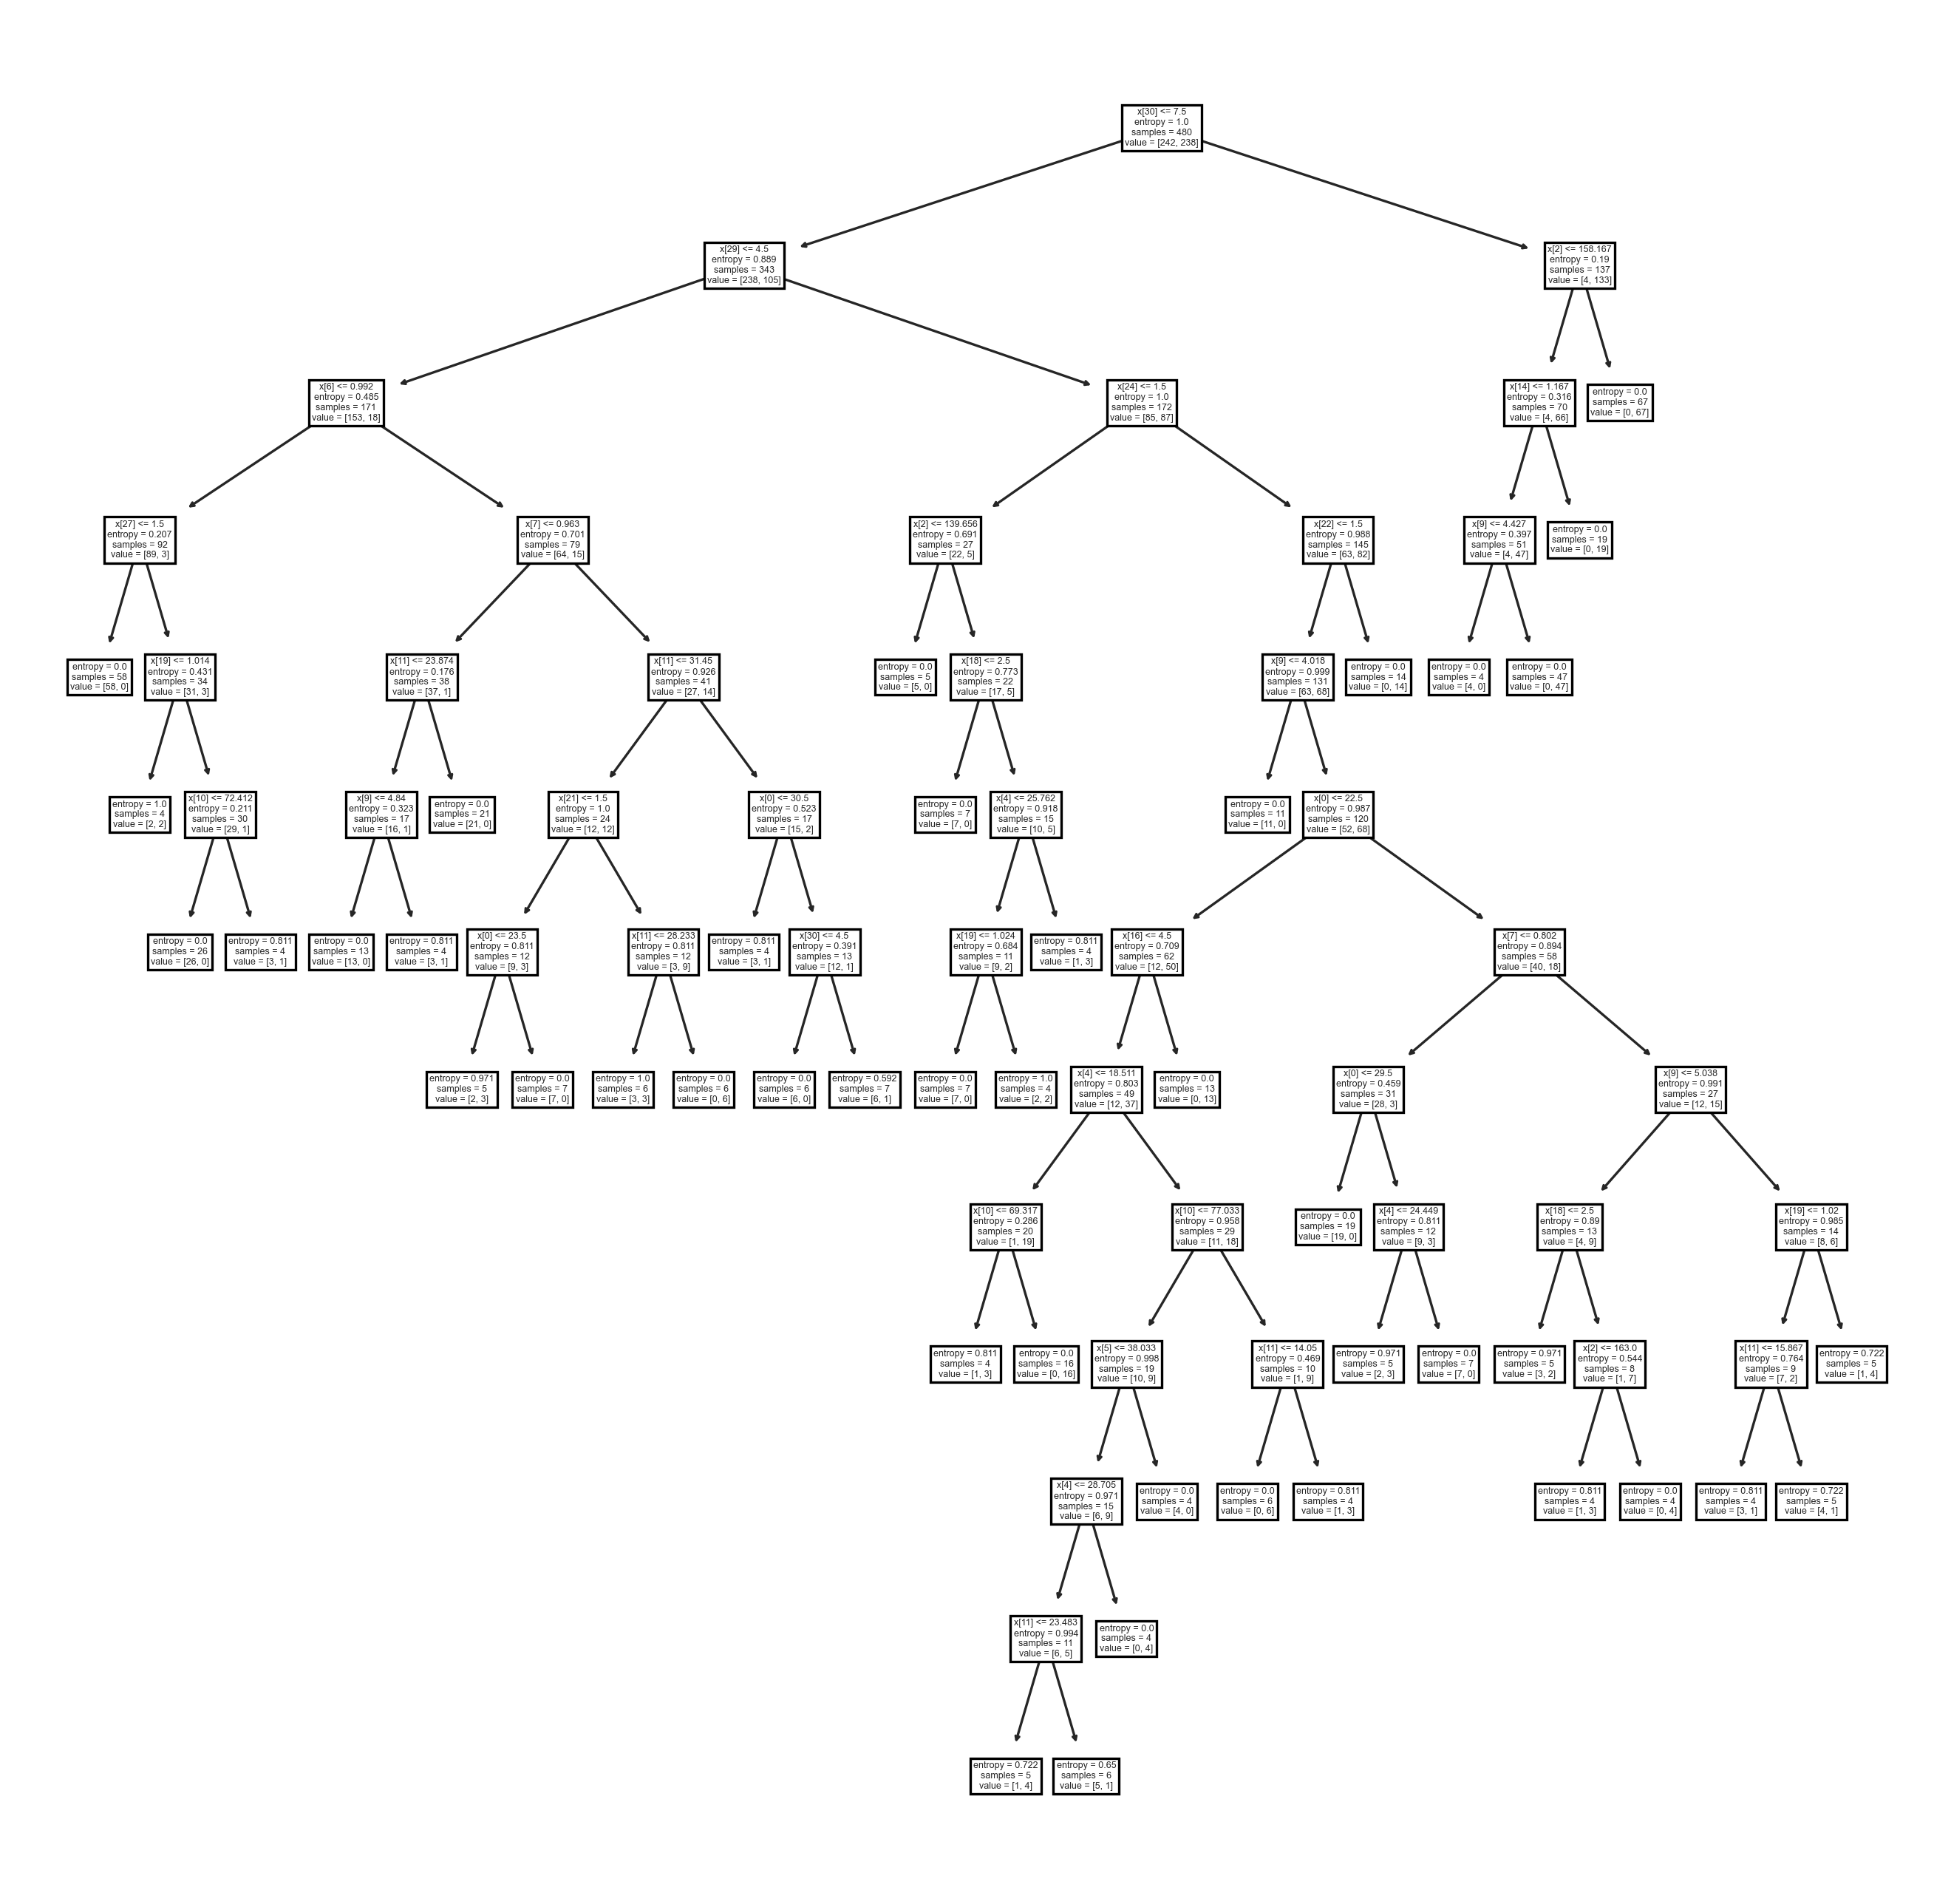

In [76]:
from sklearn import tree

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=800)
tree.plot_tree(dtc_best_parm)
fig.savefig('dtc_tree.png')

### **4. GradientBoostingClassifier**

#### Hyperparameters

**1. `learning_rate`**:

**1. `learning_rate`**:

- **Objective**: Controls the contribution of each tree to the ensemble.
- **Positive Effects**: A lower learning rate can make the model more robust to **overfitting** and improve generalization.
- **Negative Effects**: Setting it too low can result in slow convergence and require more trees for the model to reach optimal performance.
- **Solving/Prevention**: Choose an appropriate learning rate based on the dataset and desired trade-off between model complexity and convergence speed. Lower values require more trees but can improve generalization.

**2. `n_estimators`**:

- **Objective**: The number of boosting stages or trees to build.
- **Positive Effects**: Increasing the number of estimators can improve model performance by reducing bias and variance and **avoiding overfitting**.
- **Negative Effects**: Setting it too high can lead to **overfitting** and longer training time.
- **Solving/Prevention**: Choose an appropriate number of estimators based on the dataset and computational resources. Balance between model complexity and training time.

**3. `max_depth`**:

- **Objective**: The maximum depth of the individual decision trees.
- **Positive Effects**: Controlling the tree depth helps **prevent overfitting** and improves model generalization.
- **Negative Effects**: Setting it too high can result in **overfitting** and slower training time.
- **Solving/Prevention**: Choose an appropriate max depth based on the complexity of the problem and available data. Deeper trees can capture more complex relationships but increase the risk of **overfitting**.

**4. `min_samples_split`**:

- **Objective**: The minimum number of samples required to split an internal node.
- **Positive Effects**: Controlling the minimum samples for splitting helps **prevent overfitting** and improves generalization.
- **Negative Effects**: Setting it too high can result in underfitting and reduced model performance.
- **Solving/Prevention**: Choose an appropriate value for min_samples_split based on the dataset and desired trade-off between model complexity and generalization. Higher values promote simplicity, while lower values capture more details.

**5. `min_samples_leaf`**:

- **Objective**: The minimum number of samples required to be at a leaf node.
- **Positive Effects**: Controlling the minimum samples per leaf helps **prevent overfitting** and improves generalization.
- **Negative Effects**: Setting it too high can result in underfitting and reduced model performance.
- **Solving/Prevention**: Choose an appropriate value for min_samples_leaf based on the dataset and desired trade-off between model complexity and generalization. Higher values promote simplicity, while lower values capture more details.

**6. `max_features`**:

- **Objective**: The maximum number of features to consider when looking for the best split.
- **Positive Effects**: Controlling the number of features considered helps **prevent overfitting** and improves generalization.
- **Negative Effects**: Setting it too low can result in underfitting and reduced model performance.
- **Solving/Prevention**: Choose an appropriate value for max_features based on the dataset and desired trade-off between model complexity and generalization. Lower values promote simplicity, while higher values capture more information.

In [77]:
param_grid_gbc = {'learning_rate': np.linspace(0.01, 1.0, 10),
                  'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 3]}

In [78]:
gbc = GradientBoostingClassifier()

In [79]:
%%time
grid_search_gbc = GridSearchCV(gbc, param_grid_gbc, cv=5,return_train_score=True,)
grid_search_gbc.fit(X_train, y_train)

CPU times: total: 17min 3s
Wall time: 17min 7s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128]},
             return_train_score=True)

In [80]:
print('Gradient Boosting Classifier')
print('Best parameters:', grid_search_gbc.best_params_)
print('Best score:', grid_search_gbc.best_score_)
gbc_result = pd.DataFrame(grid_search_gbc.cv_results_)

Gradient Boosting Classifier
Best parameters: {'learning_rate': 0.89, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 128}
Best score: 0.9416666666666667


### **5. AdaBoostClassifier**

### Hyperparameters

**1. `base_estimator`**:

- **Objective**: The base estimator or weak learner used in the boosting process.
- **Positive Effects**: Choosing a strong base estimator can improve the overall performance of the AdaBoost model.
- **Negative Effects**: Choosing a weak base estimator may limit the model's ability to learn complex patterns in the data.
- **Solving/Prevention**: Select an appropriate base estimator based on the problem at hand. Common choices include decision trees with limited depth (e.g., **`DecisionTreeClassifier(max_depth=1)`**) or linear models (e.g., **`LogisticRegression`**).

**2. `n_estimators`**:

- **Objective**: The maximum number of estimators or iterations to build.
- **Positive Effects**: **Increasing** the number of estimators can <u>improve</u> the model's performance by <u>reducing</u> **bias** and **variance**.
- **Negative Effects**: Setting it too high can lead to overfitting and longer training time.
- **Solving/Prevention**: Choose an appropriate number of estimators based on the dataset and computational resources. Balance between model complexity and training time.

**3. `learning_rate`**:

- **Objective**: Controls the contribution of each base estimator to the ensemble.
- **Positive Effects**: A **lower learning rate** can make the model more robust to **overfitting** and improve generalization.
- **Negative Effects**: Setting it too low can result in slow convergence and require more estimators for the model to reach optimal performance.
- **Solving/Prevention**: Choose an appropriate learning rate based on the dataset and desired trade-off between model complexity and convergence speed. Lower values require more estimators but can improve generalization.

**4. `algorithm`**:

- **Objective**: The algorithm used to update the weights of the training instances.
- **Positive Effects**: Different algorithms may provide better results depending on the characteristics of the dataset.
- **Negative Effects**: Choosing an inappropriate algorithm may lead to suboptimal performance.
- **Solving/Prevention**: Select the appropriate algorithm based on the dataset and problem requirements. Common choices include **`'SAMME'`** (Discrete AdaBoost) and **`'SAMME.R'`** (Real AdaBoost).

In [81]:
param_grid_abc = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128],
    'learning_rate': np.linspace(0.01, 1.0, 10),
    'base_estimator': [
        DecisionTreeClassifier(**grid_search_dtc.best_params_),
        LogisticRegression(**grid_search_lr.best_params_)
    ]
}

In [82]:
abc = AdaBoostClassifier()

In [83]:
%%time
grid_search_abc = GridSearchCV(
    abc, param_grid_abc, cv=5, return_train_score=True,)
grid_search_abc.fit(X_train, y_train)

CPU times: total: 3min 35s
Wall time: 3min 38s


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [DecisionTreeClassifier(criterion='entropy',
                                                                   max_depth=20,
                                                                   max_features='sqrt',
                                                                   min_samples_leaf=4,
                                                                   min_samples_split=5),
                                            LogisticRegression(C=0.67,
                                                               penalty='l1',
                                                               solver='liblinear')],
                         'learning_rate': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128]},
             return_train_score=True)

In [84]:
print('AdaBoost Classifier')
print('Best parameters:', grid_search_abc.best_params_)
print('Best score:', grid_search_abc.best_score_)
abc_result = pd.DataFrame(grid_search_abc.cv_results_)

AdaBoost Classifier
Best parameters: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5), 'learning_rate': 0.34, 'n_estimators': 64}
Best score: 0.9291666666666668


### 6. GaussianNB 
No significant hyperparameters to tune.

### **7. LGBMClassifier**

#### Hyperparameters

**1. `learning_rate`**:

- **Objective**: Controls the step size shrinkage used in the boosting process.
- **Positive Effects**: A smaller learning rate can make the model more robust to overfitting and improve generalization.
- **Negative Effects**: Setting it too low can result in slower convergence and require more boosting rounds to reach optimal performance.
- **Solving/Prevention**: Choose an appropriate learning rate based on the dataset and desired **trade-off** between model complexity and **convergence speed**. **Lower** values require more boosting rounds but can improve generalization.

**2. `n_estimators`**:

- **Objective**: The number of boosting rounds or trees to build.
- **Positive Effects**: Increasing the number of estimators can improve the model's performance by <u>reducing</u> **bias** and **variance**.
- **Negative Effects**: Setting it **too high** can <u>lead</u> to **overfitting** and **longer** training time.
- **Solving/Prevention**: Choose an appropriate **number** of **`estimators`** <u>based on</u> the dataset and computational resources. Balance between model complexity and training time.

**3. `max_depth`**:

- **Objective**: The maximum depth of each tree in the ensemble.
- **Positive Effects**: Increasing the maximum depth can increase the model's capacity to learn complex patterns.
- **Negative Effects**: Setting it **too high** can <u>lead</u> to **overfitting** and **longer** training time.
- **Solving/Prevention**: Set an appropriate maximum depth based on the dataset and desired **trade-off** between model complexity and training time. Limiting the maximum depth can help prevent overfitting.

**4. `num_leaves`**:

- **Objective**: The maximum number of leaves per tree.
- **Positive Effects**: Increasing the number of leaves can increase the model's capacity to learn complex patterns.
- **Negative Effects**: Setting it **too high** can <u>lead</u> to **overfitting** and **longer** training time.
- **Solving/Prevention**: Choose an appropriate number of leaves based on the dataset and desired **trade-off** between model complexity and training time. Limiting the number of leaves can help prevent overfitting.

**5. `subsample`**:

- **Objective**: The fraction of samples to be used for training each tree.
- **Positive Effects**: Using a smaller subsample can improve the model's robustness to overfitting and improve generalization.
- **Negative Effects**: Setting it **too low** can result in <u>increased</u> **bias** and <u>reduced</u> model performance.
- **Solving/Prevention**: Choose an appropriate subsample size based on the dataset and desired **trade-off** between model complexity and generalization. Experimentation can help find the optimal subsample size.

**6. `colsample_bytree`**:

- **Objective**: The fraction of features to be used for training each tree.
- **Positive Effects**: Using a smaller fraction of features can improve the model's robustness to overfitting and improve generalization.
- **Negative Effects**: Setting it **too low** can result in decreased model performance.
- **Solving/Prevention**: Choose an appropriate fraction of features based on the dataset and desired trade-off between model complexity and generalization. Experimentation can help find the optimal feature fraction.

In [85]:
param_grid_lgbmc = {
    'n_estimators': [1, 25, 50, 100],
    'max_depth': [3, 5, 7],  
    'learning_rate': [0.01, 0.1, 0.3,0.5],  #
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],  
    'scale_pos_weight': [200/300],
    'random_state': [42] 
}


In [86]:
lgbmc = LGBMClassifier()


In [87]:
%%time
grid_search_lgbmc = GridSearchCV(
    lgbmc, param_grid_lgbmc, cv=5, return_train_score=True,)
grid_search_lgbmc.fit(X_train, y_train)

CPU times: total: 51min 32s
Wall time: 5min 21s


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [1, 25, 50, 100], 'random_state': [42],
                         'reg_alpha': [0, 0.1, 0.5],
                         'reg_lambda': [0, 0.1, 0.5],
                         'scale_pos_weight': [0.6666666666666666],
                         'subsample': [0.8, 1.0]},
             return_train_score=True)

In [88]:
print('LGBM Classifier')
print('Best parameters:', grid_search_lgbmc.best_params_)
print('Best score:', grid_search_lgbmc.best_score_)
lgbmc_result = pd.DataFrame(grid_search_lgbmc.cv_results_)


LGBM Classifier
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.1, 'scale_pos_weight': 0.6666666666666666, 'subsample': 0.8}
Best score: 0.9270833333333334


### **8. XGBClassifier**

#### Hyperparameters

**1. `learning_rate`**:

- **Objective**: Controls the step size shrinkage used in the boosting process.
- **Positive Effects**: A smaller learning rate can make the model more robust to overfitting and improve generalization.
- **Negative Effects**: Setting it **too low** can result in **slower convergence** and require more boosting rounds to reach optimal performance.
- **Solving/Prevention**: Choose an appropriate learning rate based on the dataset and desired **trade-off** between model complexity and convergence speed. Lower values require more boosting rounds but can improve generalization.

**2. `n_estimators`**:

- **Objective**: The number of boosting rounds or trees to build.
- **Positive Effects**: Increasing the number of estimators can improve the model's performance by reducing bias and variance.
- **Negative Effects**: Setting it **too high** can <u>lead</u> to **overfitting** and **longer** training time.
- **Solving/Prevention**: Choose an appropriate **number** of `estimators` <u>based on</u> the dataset and ***computational resources**. Balance between model complexity and training time.

**3. `max_depth`**:

- **Objective**: The maximum depth of each tree in the ensemble.
- **Positive Effects**: Increasing the maximum depth can increase the model's capacity to learn complex patterns.
- **Negative Effects**: Setting it **too high** can <u>lead</u> to overfitting and longer training time.
- **Solving/Prevention**: Set an appropriate maximum depth <u>based on</u> the dataset and desired **trade-off** between model complexity and training time. Limiting the maximum depth can help <u>prevent **overfitting**.</u>

**4. `subsample`**:

- **Objective**: The fraction of samples to be used for training each tree.
- **Positive Effects**: Using a smaller subsample can improve the model's robustness to overfitting and improve generalization.
- **Negative Effects**: Setting it **too low** can result in <u>increased</u> **bias** and reduced model performance.
- **Solving/Prevention**: Choose an appropriate subsample size based on the dataset and desired trade-off between model complexity and generalization. Experimentation can help find the optimal subsample size.

**5. `colsample_bytree`**:

- **Objective**: The fraction of features to be used for training each tree.
- **Positive Effects**: Using a smaller fraction of features can improve the model's robustness to overfitting and improve generalization.
- **Negative Effects**: Setting it **too low** can result in decreased model performance.
- **Solving/Prevention**: Choose an appropriate fraction of features <u>based on</u> the dataset and desired **trade-off** between model complexity and generalization. Experimentation can help find the optimal feature fraction.

**6. `reg_alpha`** and **`reg_lambda`**:

- **Objective**: L1 and L2 regularization terms to control the model's complexity.
- **Positive Effects**: Regularization can help <u>prevent **overfitting**</u> and improve generalization.
- **Negative Effects**: Setting the regularization terms **too high** can result in <u>increased</u> **bias** and reduced model performance.
- **Solving/Prevention**: Choose appropriate regularization terms <u>based on</u> the dataset and desired **trade-off** between model complexity and generalization. Experimentation can help find the optimal regularization values.

In [89]:
param_grid_xgbc = {
    'n_estimators': [1, 25, 50, 100],  
    'max_depth': [3, 5, 7],  
    'learning_rate': [0.01, 0.1, 0.3],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5], 
    'reg_lambda': [0, 0.1, 0.5], 
    'scale_pos_weight': [200/300],
    'random_state': [42]  
}

In [90]:
xgbc = XGBClassifier()

In [91]:
%%time
grid_search_xgbc = GridSearchCV(
    xgbc, param_grid_xgbc, cv=5, return_train_score=True,)
grid_search_xgbc.fit(X_train, y_train)


CPU times: total: 3h 43min 56s
Wall time: 23min 28s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [1, 25, 50, 100], 'random_state': [42],
                         'reg_alpha': [0, 0.1, 0.5],
                         'reg_lambda': [0, 0.1, 0.5],
                         'scale_pos_weight': [0.6666666666666666],
                         'subsample': [0.8, 1.0]},
             return_train_score=True)

In [92]:
print('XGB Classifier')
print('Best parameters:', grid_search_xgbc.best_params_)
print('Best score:', grid_search_xgbc.best_score_)
xgbc_result = pd.DataFrame(grid_search_xgbc.cv_results_)

XGB Classifier
Best parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 0.6666666666666666, 'subsample': 1.0}
Best score: 0.9270833333333334


### **9. KNeighborsClassifier**

#### Hyperparameters

**1. `n_neighbors`**:

- **Objective**: The number of neighbors to consider for classification.
- **Positive Effects**: Increasing the number of neighbors can improve the robustness of the model by <u>reducing</u> the **impact** of **outliers** and **noisy** data points.
- **Negative Effects**: Setting it **too high** can result in **oversmoothing** of the **decision boundary** and loss of local patterns.
- **Solving/Prevention**: Choose an appropriate number of **`neighbors`** <u>based on</u> the dataset and desired **trade-off** between local patterns and generalization. Consider the inherent structure and complexity of the data.

**2. `weights`**:

- **Objective**: The weight function used in prediction.
- **Positive Effects**: Assigning different weights to **`neighbors`** <u>based on</u> their distance can give more importance to closer neighbors and improve the model's performance.
- **Negative Effects**: Setting it inappropriately can <u>lead</u> to **biased** predictions.
- **Solving/Prevention**: Choose an appropriate weight function <u>based on</u> the dataset and **problem**. Options include uniform weights (all neighbors have the same weight) and distance weights (closer neighbors have higher weight).

**3. `algorithm`**:

- **Objective**: The algorithm used to compute the nearest neighbors.
- **Positive Effects**: Choosing the right algorithm can significantly impact the model's training and prediction speed.
- **Negative Effects**: Choosing an inefficient algorithm can result in **longer** processing times.
- **Solving/Prevention**: <u>Consider</u> the size of the dataset and available **computational resources** when choosing the algorithm. Options include 'auto' (automatically selects the most suitable algorithm), 'ball_tree', 'kd_tree', and 'brute'.

**4. `leaf_size`**:

- **Objective**: The size of the leaf node used in the tree-based algorithms for efficient searching.
- **Positive Effects**: Choosing an appropriate leaf size can optimize the **search time** and **memory usage**.
- **Negative Effects**: Setting it **too low** can result in <u>increased</u> **memory usage** and slower performance.
- **Solving/Prevention**: Experiment with different leaf sizes <u>based on</u> the **dataset size** and **available resources**. Find a balance between search efficiency and memory usage.

**5. `p`**:

- **Objective**: The power parameter for the Minkowski metric.
- **Positive Effects**: Choosing the right power parameter can affect the way distances are calculated and influence the model's performance.
- **Negative Effects**: Setting it inappropriately can result in biased distance calculations.
- **Solving/Prevention**: Experiment with different power parameters <u>based on</u> the dataset and **problem**. The default value of **`p=2`** corresponds to the standard **Euclidean distance**.

In [93]:
param_grid_knc = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40, 50], 
    'p': [1, 2]
}

In [94]:
knc = KNeighborsClassifier()

In [95]:
%%time
grid_search_knc = GridSearchCV(
    knc, param_grid_knc, cv=5, return_train_score=True,)
grid_search_knc.fit(X_train, y_train)

CPU times: total: 1min 41s
Wall time: 27.6 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30, 40, 50], 'n_neighbors': [3, 5, 7, 9],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True)

In [96]:
print('KNeighbors Classifier')
print('Best parameters:', grid_search_knc.best_params_)
print('Best score:', grid_search_knc.best_score_)
knc_result = pd.DataFrame(grid_search_knc.cv_results_)

KNeighbors Classifier
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: 0.8625


### **10. DummyClassifier**
(Baseline model)
### Hyperparameters

**1. `strategy`**:

- **Objective**: The strategy used to generate dummy predictions.
- **Positive Effects**: Choosing an **appropriate** **`strategy`** can provide a baseline for model performance **evaluation** and **comparison**.
- **Negative Effects**: Dummy classifiers do **not learn** from the data, so their predictive power is limited.
- **Solving/Prevention**: Select a **`strategy`** that aligns with the problem at hand and the desired baseline. 
    - Options include 
        - **'stratified'** (generates predictions by respecting the class distribution in the training data), 
        - **'most_frequent'** (always predicts the most frequent class), 
        - **'prior'** (uses class probabilities as prior probabilities for prediction),  
        - **'uniform'** (predicts uniformly at random).

**2. `random_state`**:

- **Objective**: The random seed <u>used</u> for **reproducibility**.
- **Positive Effects**: Setting a random seed ensures consistent and reproducible results across different runs of the model.
- **Negative Effects**: Not setting a random seed can <u>lead</u> to **different results** each time the model is **run**.
- **Solving/Prevention**: Set a <u>fixed</u> random **seed value** to ensure consistent results for comparison and reproducibility purposes.

In [97]:
param_grid_dummyc = {
    'strategy': ['stratified', 'most_frequent', 'uniform']
}

In [98]:
dummyc = DummyClassifier()

In [99]:
%%time
grid_search_dummyc = GridSearchCV(
    dummyc, param_grid_dummyc, cv=5, return_train_score=True,)
grid_search_dummyc.fit(X_train, y_train)


CPU times: total: 46.9 ms
Wall time: 46.3 ms


GridSearchCV(cv=5, estimator=DummyClassifier(),
             param_grid={'strategy': ['stratified', 'most_frequent',
                                      'uniform']},
             return_train_score=True)

In [100]:
print('Dummy Classifier')
print('Best parameters:', grid_search_dummyc.best_params_)
print('Best score:', grid_search_dummyc.best_score_)
dummyc_result = pd.DataFrame(grid_search_dummyc.cv_results_)

Dummy Classifier
Best parameters: {'strategy': 'stratified'}
Best score: 0.55625


In [101]:
tuned_rf = grid_search_rf.best_estimator_
tuned_lr = grid_search_lr.best_estimator_
tuned_gbc = grid_search_gbc.best_estimator_
tuned_abc = grid_search_abc.best_estimator_
tuned_dtc = grid_search_dtc.best_estimator_
tuned_lgbmc = grid_search_lgbmc.best_estimator_
tuned_xgbc = grid_search_xgbc.best_estimator_
tuned_knc = grid_search_knc.best_estimator_
tuned_dummyc = grid_search_dummyc.best_estimator_
gnb = GaussianNB()

tuned_models = [('Random Forest', tuned_rf), ('Logistic Regression', tuned_lr),
                ('Gradient Boosting Classifier', tuned_gbc),
                ('AdaBoostClassifier',tuned_abc), ('GaussianNB', gnb),
                ('LGBMClassifier', tuned_lgbmc), ('XGBClassifier', tuned_xgbc),
                ('KNeighborsClassifier',
                 tuned_knc), ('DecisionTreeClassifier', tuned_dtc),
                ('DummyClassifier_most_frequent', tuned_dummyc)]

## Model Evaluation

In [102]:
tuned_performances = modeling(
    tuned_models, X_train, X_test, y_train, y_test)
tuned_performances

Model Runtime Performance       AUC   TP   FP  \
0                   Random Forest     0.0       Train  0.951958  234    8   
1                   Random Forest     0.0        Test  0.892937   54    4   
2             Logistic Regression     0.0       Train  0.924960  225   17   
3             Logistic Regression     0.0        Test  0.900445   53    5   
4    Gradient Boosting Classifier     0.0       Train  1.000000  242    0   
5    Gradient Boosting Classifier     0.0        Test  0.932703   53    5   
6              AdaBoostClassifier     0.0       Train  1.000000  242    0   
7              AdaBoostClassifier     0.0        Test  0.933259   54    4   
8                      GaussianNB     0.0       Train  0.878811  223   19   
9                      GaussianNB     0.0        Test  0.892937   54    4   
10                 LGBMClassifier     0.0       Train  0.997934  241    1   
11                 LGBMClassifier     0.0        Test  0.916574   53    5   
12                  XGBClassifier     0.0       Train  0.981092  242    0   
13                  XGBClassifier     0.0        Test  0.925195   54    4   
14           KNeighborsClassifier     0.0       Train  1.000000  242    0   
15           KNeighborsClassifier     0.0        Test  0.808954   48   10   
16         DecisionTreeClassifier     0.0       Train  0.918519  229   13   
17         DecisionTreeClassifier     0.0        Test  0.768076   47   11   
18  DummyClassifier_most_frequent     0.0       Train  0.495972  116  126   
19  DummyClassifier_most_frequent     0.0        Test  0.520578   37   21   

     FN   TN  Precision    Recall  Accuracy  
0    15  223   0.952457  0.952083  0.952083  
1     9   53   0.894695  0.891667  0.891667  
2    19  219   0.925024  0.925000  0.925000  
3     7   55   0.900556  0.900000  0.900000  
4     0  238   1.000000  1.000000  1.000000  
5     3   59   0.933743  0.933333  0.933333  
6     0  238   1.000000  1.000000  1.000000  
7     4   58   0.933333  0.933333  0.933333  
8    39  199   0.881737  0.879167  0.879167  
9     9   53   0.894695  0.891667  0.891667  
10    0  238   0.997925  0.997917  0.997917  
11    5   57   0.916667  0.916667  0.916667  
12    9  229   0.981922  0.981250  0.981250  
13    5   57   0.925160  0.925000  0.925000  
14    0  238   1.000000  1.000000  1.000000  
15   13   49   0.809424  0.808333  0.808333  
16   26  212   0.919947  0.918750  0.918750  
17   17   45   0.770126  0.766667  0.766667  
18  116  122   0.496001  0.495833  0.495833  
19   37   25   0.522464  0.516667  0.516667

## Learning curve

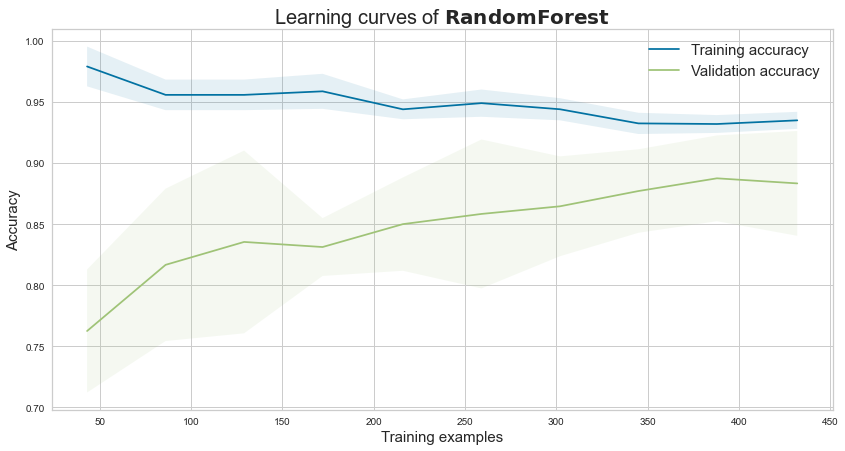

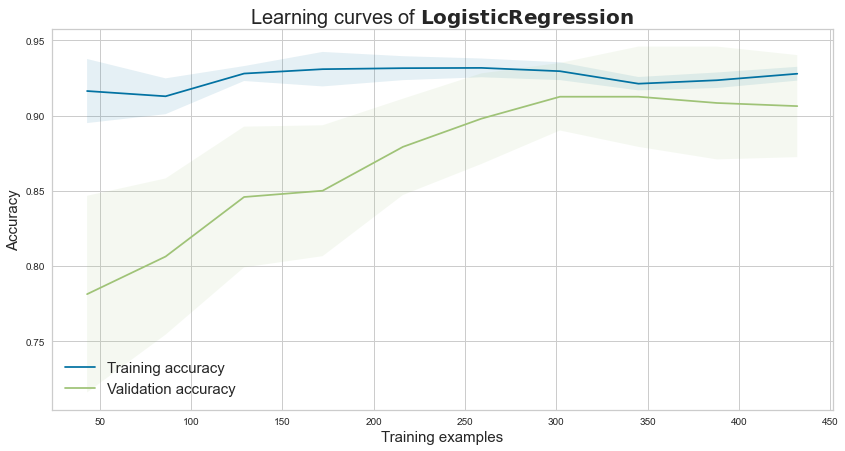

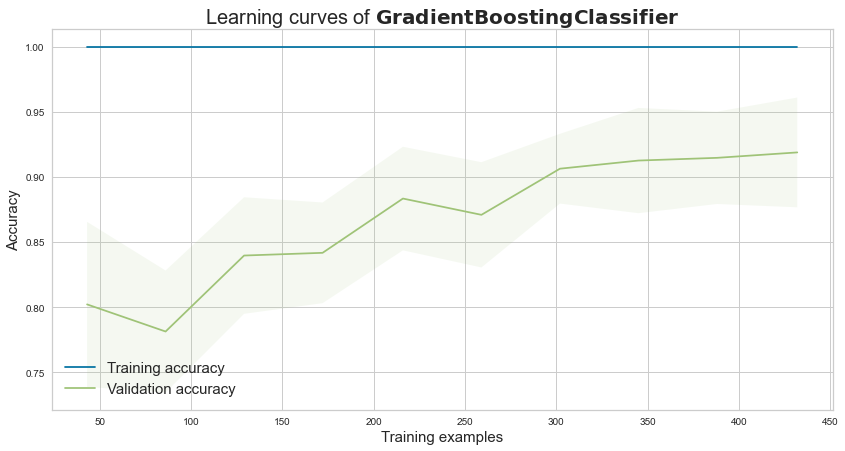

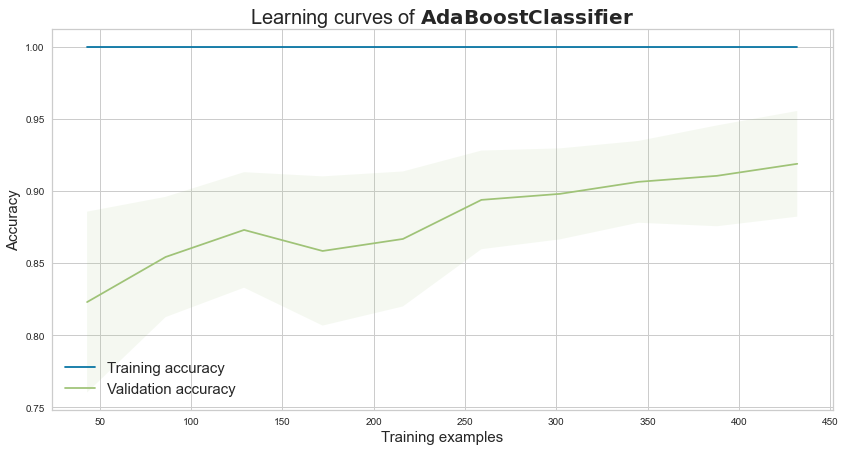

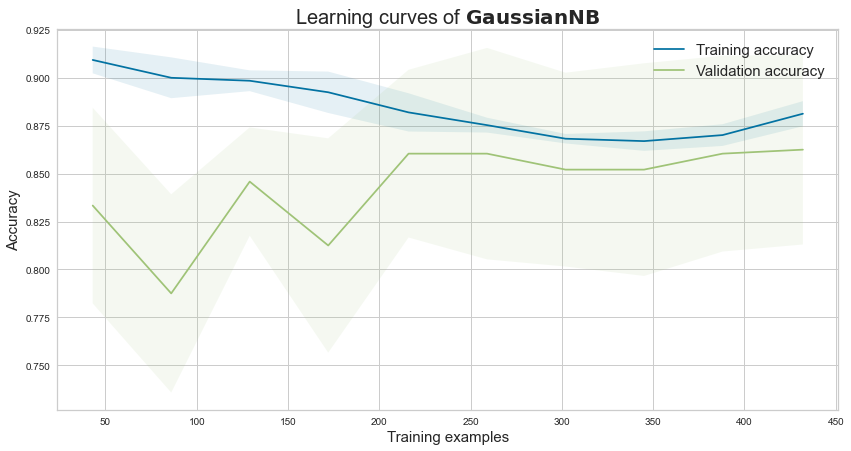

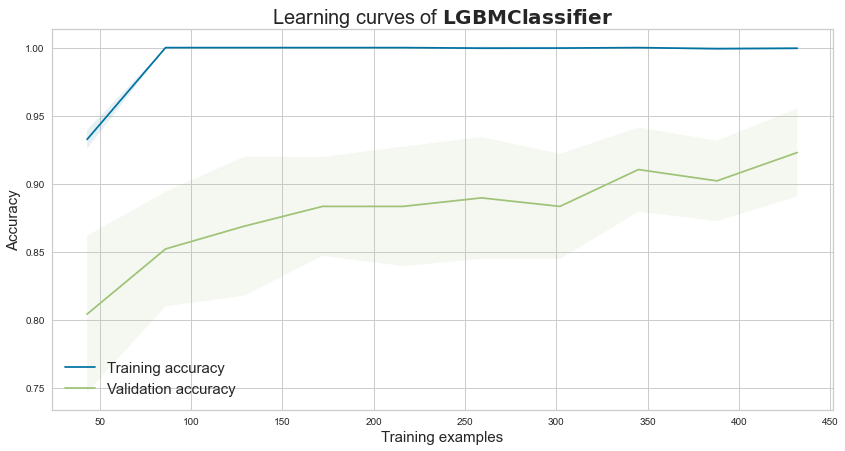

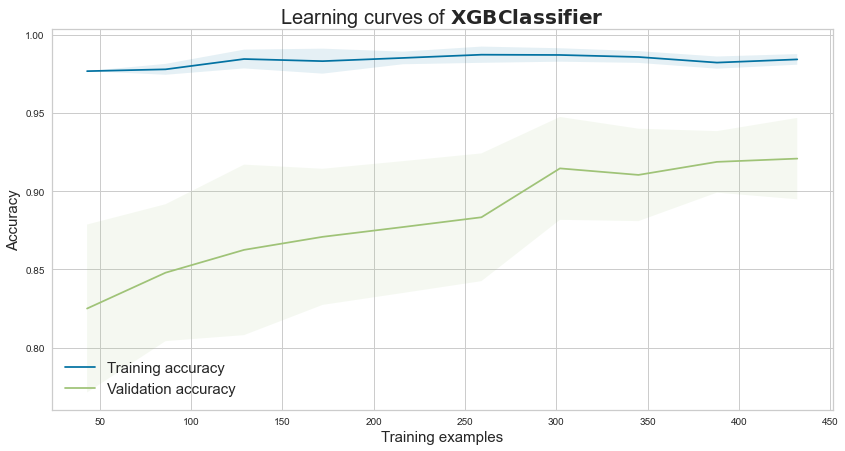

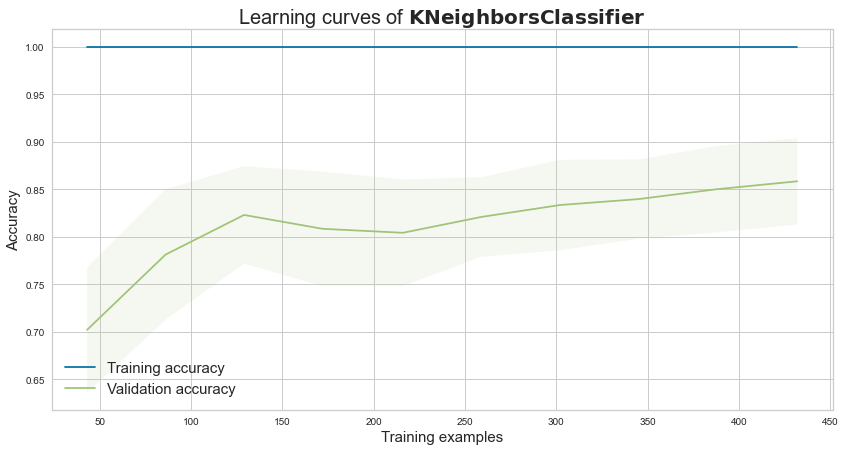

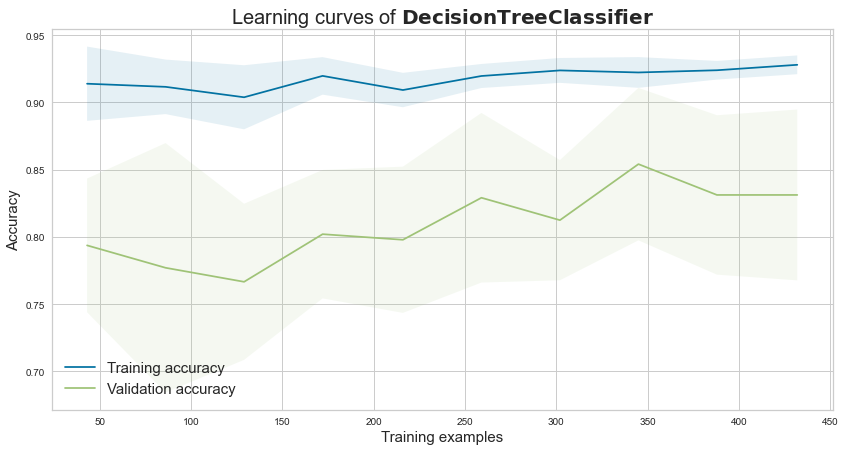

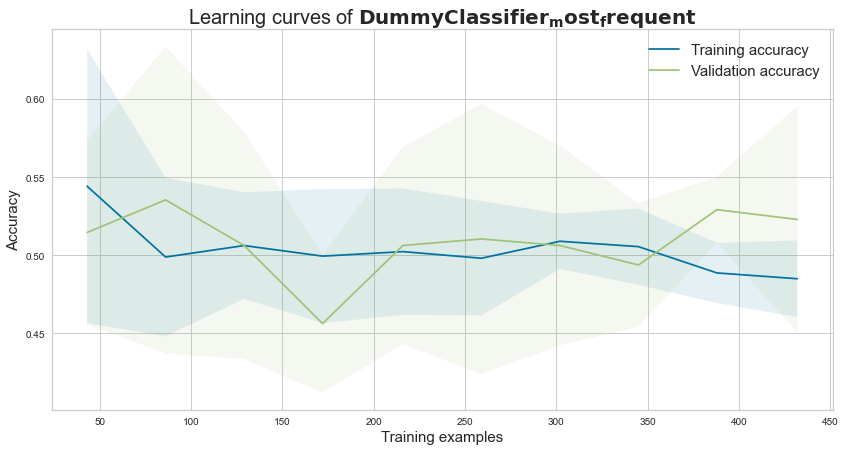

In [103]:
for name, model in tuned_models:
    viz_learning_curve(name,model, X_train, y_train)

### Overall (Test Performance)

In [104]:
color_mapping = {
    'Random Forest': 'blue',
    'Logistic Regression': 'orange',
    'Gradient Boosting Classifier': 'green',
    'AdaBoostClassifier': 'red',
    'GaussianNB': 'purple',
    'LGBMClassifier': 'cyan',
    'XGBClassifier': 'magenta',
    'KNeighborsClassifier': 'brown',
    'DecisionTreeClassifier': 'gray',
    'DummyClassifier_most_frequent': 'black'
}

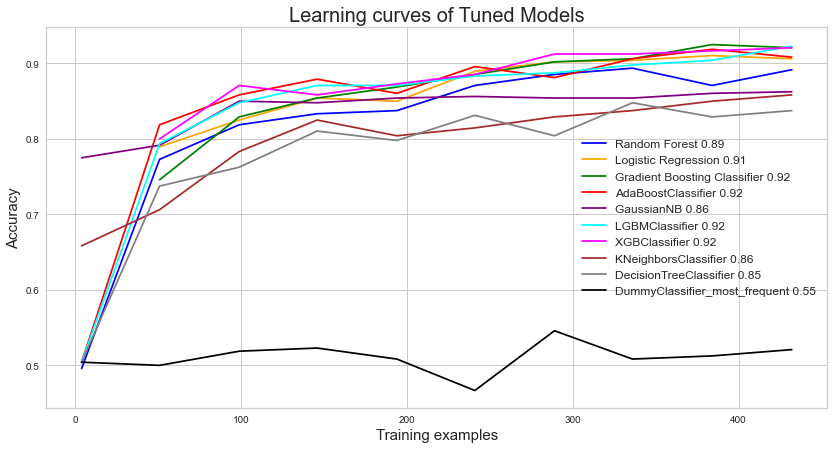

In [105]:
fig = plt.figure(figsize=(14, 7))

for model_name, model in tuned_models:
    train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train,
                                                             train_sizes=np.linspace(0.01, 1.0, 10), cv=10)
    
    valid_mean = np.mean(valid_scores, axis=1)

    color = color_mapping[model_name]
    max_accuracy = np.nanmax(valid_mean).round(2)
    # Validation Line
    plt.plot(train_sizes, valid_mean,
             label=f'{model_name} {max_accuracy}', color=color)
plt.legend(loc='best', fontsize=12)
plt.xlabel('Training examples', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Learning curves of Tuned Models', fontsize=20)

plt.show()

### Save model

In [106]:
# save models
for name, model in tuned_models:
    file_name = name.replace(' ', '_')
    joblib.dump(model, f'model/model_{file_name}.pkl')

## Confusion Matrixes

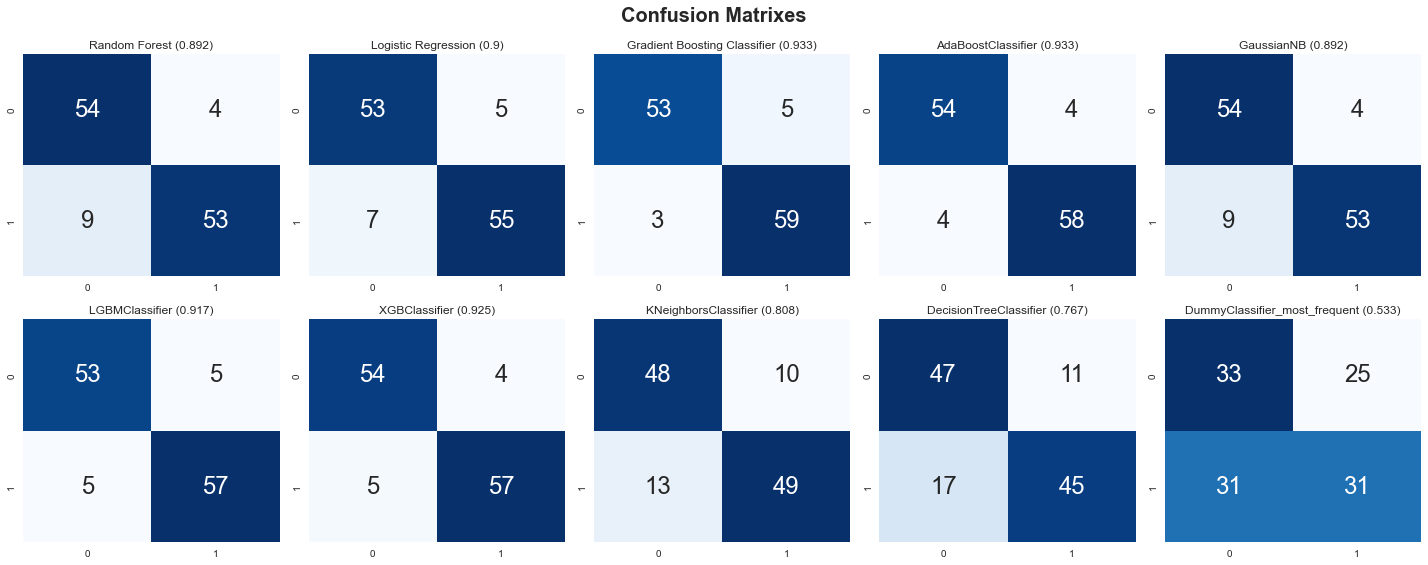

In [107]:
n_rows = 2
n_cols = 5
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
fig.suptitle('Confusion Matrixes', fontsize=20, fontweight='bold')
index = 0
for name, model in tuned_models:
    row = index // n_cols
    col = index % n_cols
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    axes[row][col].set_title(f'{name} ({accuracy.round(3)})')
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", ax=axes[row][col],
                cbar=False, annot_kws={"size": 24})
    index+=1
plt.tight_layout()
plt.show()

## ROC 
- **Obj**: Assess and compare the performance of binary classification 
- **Insight**: model's **sensitivity** to true positives and **specificity** in avoiding false positives.

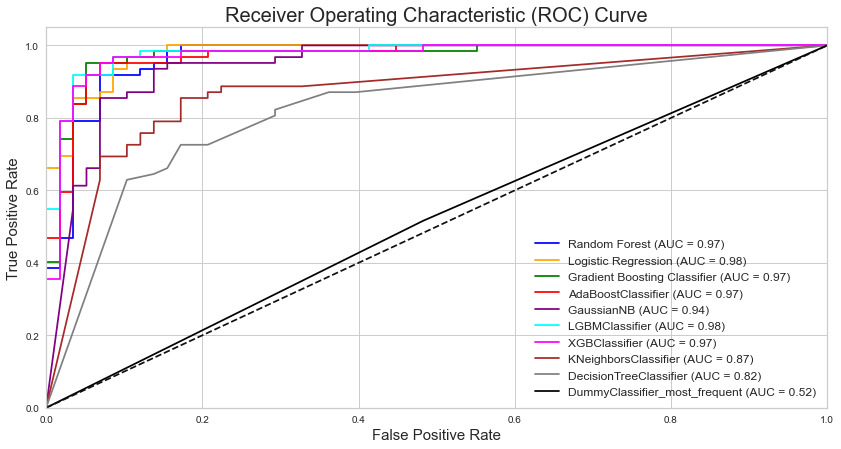

In [108]:
fig = plt.figure(figsize=(14, 7))

for model_name, model in tuned_models:
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    auc_score = roc_auc_score(y_test, y_test_prob)
    color = color_mapping[model_name]
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})',color = color)

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
plt.legend(loc='lower right', fontsize=12)

plt.show()

### Considering Model the Best Performance
<u>**Anwser**</u> **Logistic Regression** 
- **Learning curve** = **`Good Fit`** model is `performing well` and is `able` to `generalize` to new data.
- **Logistic Regression**'s **Accuracy** = Test set (0.88) worse than Others, But ability to distinguish is High (AUC = 0.98)
- **Run time** = All is 0.01 s

# Model Explainablity

## 1. Permutation Feature Importance

- **Obj**: To identify how important each feature is for predicting the outcome.  In other words which feature degraded in all models when it was absent?
- **Insight**: Relative importance of features in the model's decision-making process. It helps identify which features have the most impact on the model's predictions.
(Also) หา Features ที่มีผลต่อโมเดลในการทำนายมากที่สุด

## Library

In [109]:
# Inspection
from sklearn.inspection import permutation_importance

In [110]:
permu_f_im = permutation_importance(tuned_lr, X, y, scoring='accuracy')
importance_scores = permu_f_im.importances_mean
importance_scores

array([-0.0036,  0.0292, -0.0008, -0.0024, -0.0012, -0.0016,  0.0172,
        0.0032,  0.    ,  0.0016,  0.    , -0.0008,  0.    ,  0.    ,
        0.0016,  0.0008, -0.0048, -0.0004,  0.0004,  0.    ,  0.002 ,
        0.    ,  0.0072,  0.    ,  0.0068,  0.    , -0.0068,  0.022 ,
       -0.0056,  0.0096,  0.0076])

In [111]:
permutation_importance_df = pd.DataFrame(
    {'Feature': X.columns, 'Importance': importance_scores})
permutation_importance_df = permutation_importance_df.sort_values(
    'Importance', ascending=False)
permutation_importance_df

Feature  Importance
1                                  sex      0.0292
27                             Dysuria      0.0220
6                              alcohol      0.0172
29                 Alvarado Score (AS)      0.0096
30  Pediatric appendicitis score (PAS)      0.0076
22  Tenderness in right lower quadrant      0.0072
24                    Cough tenderness      0.0068
7                              smoking      0.0032
20      Peritonitis/abdominal guarding      0.0020
14                          Leukocytes      0.0016
9                                  RBC      0.0016
15                        Urine Ketone      0.0008
18                    Urine Leukocytes      0.0004
12                           Urine WBC      0.0000
19              Urine Specific gravity      0.0000
25                     Nausea/vomiting      0.0000
23                  Rebound tenderness      0.0000
13                           Urine RBC      0.0000
8                                  WBC      0.0000
21                   Migration of pain      0.0000
10                          Neutrophil      0.0000
17                         Urine Sugar     -0.0004
11                         Lymphocytes     -0.0008
2                               height     -0.0008
4                                  bmi     -0.0012
5                     body_temperature     -0.0016
3                          body_weight     -0.0024
0                                  age     -0.0036
16                         Urine Color     -0.0048
28                               Stool     -0.0056
26                            Anorexia     -0.0068

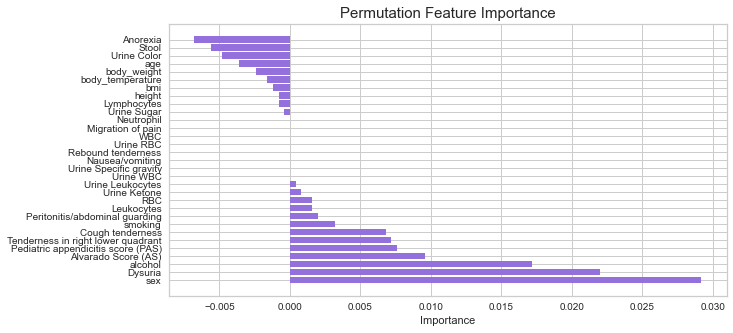

In [112]:
fig = plt.figure(figsize=(10, 5))

plt.barh(range(len(permutation_importance_df)),
         permutation_importance_df['Importance'], color='mediumpurple')
plt.yticks(range(len(permutation_importance_df)), permutation_importance_df['Feature'])
plt.xlabel('Importance')
plt.title('Permutation Feature Importance', fontsize=15)
plt.show()

## 2. SHAP
(Realm of model explainability)
- **Obj**: explain the output of any machine learning model.
- **Insight**: Relative importance of features in the model's decision-making process. It helps identify which features have the most impact on the model's predictions.

## Library

In [113]:
# pip install shap

In [114]:
import shap

In [115]:
explainer = shap.Explainer(tuned_lr, X_train)
shap_values = explainer(X_test)
shap_values

.values =
array([[ 0.00663202,  0.88028691, -0.01918233, ..., -0.33561833,
         0.01807246,  0.1929919 ],
       [-0.09089348, -0.78831762, -0.0222031 , ..., -0.33561833,
        -0.28313524, -0.15790247],
       [-0.73546098,  0.88028691, -0.04980787, ..., -0.33561833,
        -0.88555064, -0.50879684],
       ...,
       [ 0.29920852, -0.78831762, -0.01314078, ..., -0.33561833,
         0.62048786,  0.54388628],
       [-0.09089348,  0.88028691, -0.02522388, ..., -0.33561833,
         0.92169556,  0.89478065],
       [ 0.15292027,  0.88028691, -0.04485892, ..., -0.33561833,
        -0.58434294, -0.50879684]])

.base_values =
array([0.55510416, 0.55510416, 0.55510416, 0.55510416, 0.55510416,
       0.55510416, 0.55510416, 0.55510416, 0.55510416, 0.55510416,
       0.55510416, 0.55510416, 0.55510416, 0.55510416, 0.55510416,
       0.55510416, 0.55510416, 0.55510416, 0.55510416, 0.55510416,
       0.55510416, 0.55510416, 0.55510416, 0.55510416, 0.55510416,
       0.55510416, 0.55510

## Summary plot

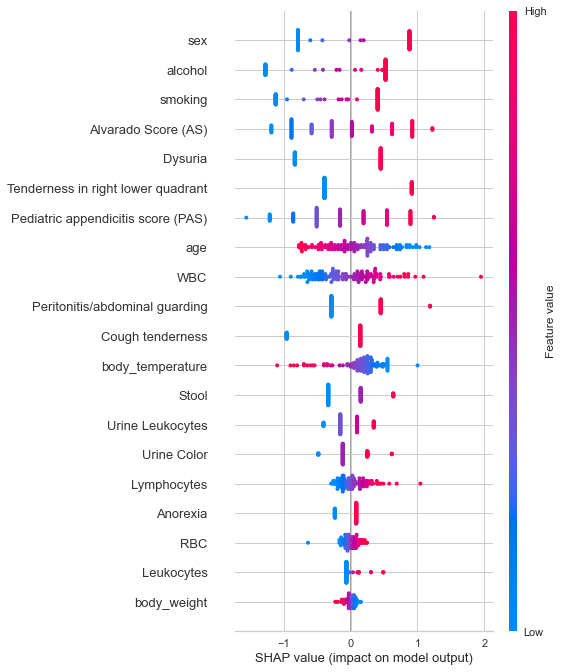

In [116]:
shap.summary_plot(shap_values, X_test)

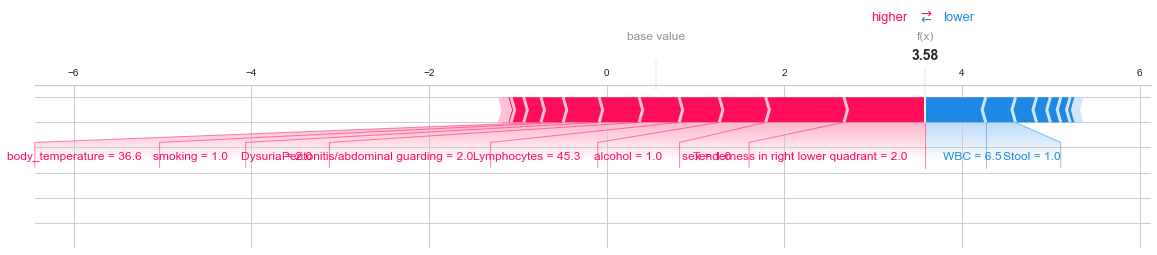

In [117]:
shap.plots.force(shap_values[0],matplotlib=True)

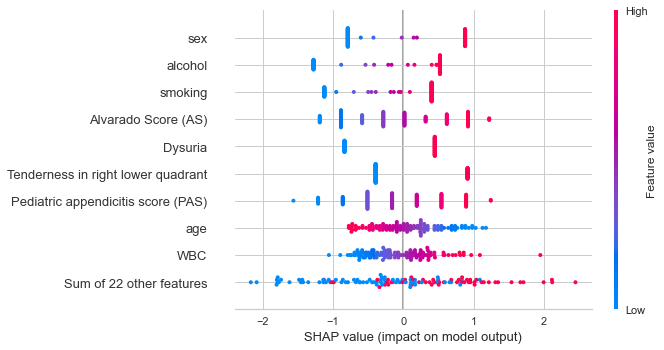

In [118]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

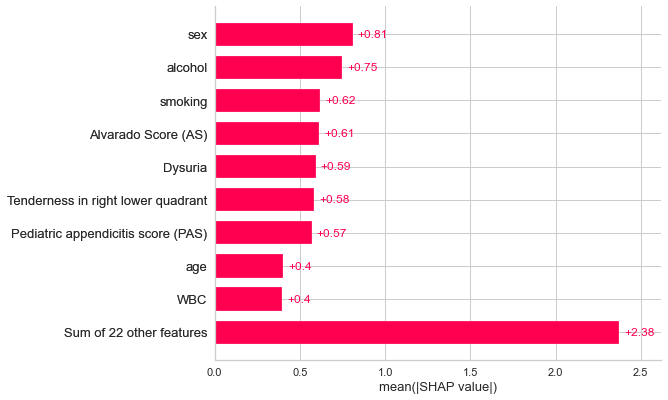

In [119]:
shap.plots.bar(shap_values)


In [120]:
permutation_importance_df

Feature  Importance
1                                  sex      0.0292
27                             Dysuria      0.0220
6                              alcohol      0.0172
29                 Alvarado Score (AS)      0.0096
30  Pediatric appendicitis score (PAS)      0.0076
22  Tenderness in right lower quadrant      0.0072
24                    Cough tenderness      0.0068
7                              smoking      0.0032
20      Peritonitis/abdominal guarding      0.0020
14                          Leukocytes      0.0016
9                                  RBC      0.0016
15                        Urine Ketone      0.0008
18                    Urine Leukocytes      0.0004
12                           Urine WBC      0.0000
19              Urine Specific gravity      0.0000
25                     Nausea/vomiting      0.0000
23                  Rebound tenderness      0.0000
13                           Urine RBC      0.0000
8                                  WBC      0.0000
21                   Migration of pain      0.0000
10                          Neutrophil      0.0000
17                         Urine Sugar     -0.0004
11                         Lymphocytes     -0.0008
2                               height     -0.0008
4                                  bmi     -0.0012
5                     body_temperature     -0.0016
3                          body_weight     -0.0024
0                                  age     -0.0036
16                         Urine Color     -0.0048
28                               Stool     -0.0056
26                            Anorexia     -0.0068

In [142]:
# 0.0016 >= So patient don't have to do Urine labs
importance_val= 0.0016

In [143]:
list(
    permutation_importance_df.loc[permutation_importance_df['Importance'] >= importance_val]['Feature'])


['sex',
 'Dysuria',
 'alcohol',
 'Alvarado Score (AS)',
 'Pediatric appendicitis score (PAS)',
 'Tenderness in right lower quadrant',
 'Cough tenderness',
 'smoking',
 'Peritonitis/abdominal guarding',
 'Leukocytes',
 'RBC']

In [171]:
# It's neccessary to and some features to re-calculate as, pas score 
# ['age', 'height', 'body_weight', 'body_temperature', 
#  'WBC',
#  'Anorexia', 'Nausea/vomiting', 'Rebound pain']

selected_cols = ['age', 'sex', 'height', 'body_weight', 'body_temperature', 'alcohol', 'smoking',
                 'Dysuria', 'Anorexia', 'Nausea/vomiting', 'Rebound tenderness',
                 'Peritonitis/abdominal guarding', 'Tenderness in right lower quadrant', 'Cough tenderness',
                 'WBC', 'RBC','Leukocytes',
                 'Alvarado Score (AS)',
                 'Pediatric appendicitis score (PAS)',
                ] 
selected_cols

['age',
 'sex',
 'height',
 'body_weight',
 'body_temperature',
 'alcohol',
 'smoking',
 'Dysuria',
 'Anorexia',
 'Nausea/vomiting',
 'Rebound tenderness',
 'Peritonitis/abdominal guarding',
 'Tenderness in right lower quadrant',
 'Cough tenderness',
 'WBC',
 'RBC',
 'Leukocytes',
 'Alvarado Score (AS)',
 'Pediatric appendicitis score (PAS)']

## Re-Training

In [172]:
%%time
rf = RandomForestClassifier()
lr = LogisticRegression()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
gnb = GaussianNB()
lgbmc = LGBMClassifier()
xgbc = XGBClassifier()
knc = KNeighborsClassifier(3)
dtc = DecisionTreeClassifier()
dummyc = DummyClassifier(strategy='most_frequent', random_state=0)

models = [('Random Forest', rf), ('Logistic Regression', lr),
          ('Gradient Boosting Classifier', gbc),
          ('AdaBoostClassifier', abc), ('GaussianNB', gnb),
          ('LGBMClassifier', lgbmc), ('XGBClassifier', xgbc),
          ('KNeighborsClassifier', knc), ('DecisionTreeClassifier', dtc),
          ('DummyClassifier_most_frequent', dummyc)]

pfi_performances = modeling(
    models, X_train.loc[:, selected_cols], X_test.loc[:, selected_cols], y_train, y_test)
pfi_performances

CPU times: total: 2.8 s
Wall time: 759 ms


Model Runtime Performance       AUC   TP  FP   FN  \
0                   Random Forest     0.0       Train  1.000000  242   0    0   
1                   Random Forest     0.0        Test  0.908509   53   5    6   
2             Logistic Regression     0.0       Train  0.918727  223  19   20   
3             Logistic Regression     0.0        Test  0.925751   55   3    6   
4    Gradient Boosting Classifier     0.0       Train  0.993732  241   1    2   
5    Gradient Boosting Classifier     0.0        Test  0.900445   53   5    7   
6              AdaBoostClassifier     0.0       Train  0.949927  232  10   14   
7              AdaBoostClassifier     0.0        Test  0.899889   52   6    6   
8                      GaussianNB     0.0       Train  0.870303  226  16   46   
9                      GaussianNB     0.0        Test  0.860679   54   4   13   
10                 LGBMClassifier     0.0       Train  0.997899  242   0    1   
11                 LGBMClassifier     0.0        Test  0.916018   52   6    4   
12                  XGBClassifier     0.0       Train  1.000000  242   0    0   
13                  XGBClassifier     0.0        Test  0.916018   52   6    4   
14           KNeighborsClassifier     0.0       Train  0.899889  221  21   27   
15           KNeighborsClassifier     0.0        Test  0.832592   47  11    9   
16         DecisionTreeClassifier     0.0       Train  1.000000  242   0    0   
17         DecisionTreeClassifier     0.0        Test  0.873471   48  10    5   
18  DummyClassifier_most_frequent     0.0       Train  0.500000  242   0  238   
19  DummyClassifier_most_frequent     0.0        Test  0.500000   58   0   62   

     TN  Precision    Recall  Accuracy  
0   238   1.000000  1.000000  1.000000  
1    56   0.908498  0.908333  0.908333  
2   218   0.918754  0.918750  0.918750  
3    56   0.926188  0.925000  0.925000  
4   236   0.993758  0.993750  0.993750  
5    55   0.900556  0.900000  0.900000  
6   224   0.950118  0.950000  0.950000  
7    56   0.900000  0.900000  0.900000  
8   192   0.876595  0.870833  0.870833  
9    49   0.867225  0.858333  0.858333  
10  237   0.997925  0.997917  0.997917  
11   58   0.917039  0.916667  0.916667  
12  238   1.000000  1.000000  1.000000  
13   58   0.917039  0.916667  0.916667  
14  211   0.900229  0.900000  0.900000  
15   53   0.833519  0.833333  0.833333  
16  238   1.000000  1.000000  1.000000  
17   57   0.877288  0.875000  0.875000  
18    0   0.254184  0.504167  0.504167  
19    0   0.233611  0.483333  0.483333

## Re-Hyperparameter tuning

#### Hyperparameter Function easy to use

In [173]:
def hyperparameter_tuning(models, X_train, X_test, y_train, y_test):
    l_performances = []

    for name, model, param_grid in models:
        start_time = time.time()

        if name == 'AdaBoostClassifier':
            path = 'model/feature_importance/grid_search/grid_search_DecisionTreeClassifier.pkl'
            grid_search_dtc = joblib.load(path)
            path = 'model/feature_importance/grid_search/grid_search_Logistic_Regression.pkl'
            grid_search_lr = joblib.load(path)
            
            param_grid['base_estimator'] = [DecisionTreeClassifier(**grid_search_dtc.best_params_),
                                            LogisticRegression(**grid_search_lr.best_params_)]
            
        # grid search
        grid_search = GridSearchCV(
                    model, param_grid, cv=5, return_train_score=True,)
        grid_search.fit(X_train, y_train)
        print(name)
        print('Best parameters:', grid_search.best_params_)
        print('Best score:', grid_search.best_score_)

        result_of_grid = pd.DataFrame(grid_search.cv_results_)
        # Save 
        result_of_grid[name] = name
        file_name = name.replace(' ', '_')
        # Save csv
        result_of_grid.to_csv(f'model/feature_importance/csv/{file_name}.csv', index=False)
        # Save grid search
        joblib.dump(
            grid_search, f'model/feature_importance/grid_search/grid_search_{file_name}.pkl')
        # Save model
        joblib.dump(grid_search.best_estimator_,
                    f'model/feature_importance/model_{file_name}.pkl')

        model = grid_search.best_estimator_
        for subset, subset_name, y_true in [(X_train, 'Train', y_train),
                                            (X_test, 'Test', y_test)]:
            y_pred = model.predict(subset)
            # Calculate ROC curve and AUC score
            fpr, tpr, thresholds = roc_curve(y_true, y_pred)
            auc_score = roc_auc_score(y_true, y_pred)
            # Classification Report
            report = classification_report(y_true, y_pred, output_dict=True)
            report_dict = json.loads(json.dumps(report))

            # Extract precision and recall from report_dict
            precision = report_dict['weighted avg']['precision']
            recall = report_dict['weighted avg']['recall']
            accuracy = report_dict['accuracy']

            # Confusion Matrix
            cm = confusion_matrix(y_true, y_pred)
            TP = cm[0][0]
            FP = cm[0][1]
            FN = cm[1][0]
            TN = cm[1][1]
            runtime = format(round((time.time() - start_time)/60, 2))
            # Dict
            my_dict = {'Model': name, 'Runtime': runtime, 'Performance': subset_name,
                       'AUC': auc_score, 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
                       'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

            l_performances.append(my_dict)
    performances = pd.DataFrame(l_performances)
    return performances

In [174]:
%%time
rf = RandomForestClassifier()
lr = LogisticRegression()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
gnb = GaussianNB()
lgbmc = LGBMClassifier()
xgbc = XGBClassifier()
knc = KNeighborsClassifier(3)
dtc = DecisionTreeClassifier()
dummyc = DummyClassifier(strategy='most_frequent', random_state=0)

models = [
    ('Random Forest', rf, 
        {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 3]}), 
        
    ('DecisionTreeClassifier', dtc,
     {'criterion': ['gini', 'entropy'],
      'max_depth': [None, 5, 10, 20],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'max_features': ['auto', 'sqrt', 'log2'], }),

    ('Logistic Regression', lr, 
        {'C': np.linspace(0.01, 1.0, 10),
        'penalty': ['l1', 'l2'],
        'solver': ['lbfgs', 'liblinear', 'saga']}),

    ('Gradient Boosting Classifier', gbc, 
        {'learning_rate': [0.01, 0.1, 1],
        'n_estimators': [1, 50, 150],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 3]}),

    ('AdaBoostClassifier', abc, {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001],
        'base_estimator': [
            DecisionTreeClassifier(),
            LogisticRegression()
        ]
    }), 

    ('LGBMClassifier', lgbmc, 
        {'n_estimators': [1, 25, 50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5],
        'scale_pos_weight': [200/300],
        'random_state': [42]}), 
        
    ('XGBClassifier', xgbc, 
        {'n_estimators': [1, 25, 50, 100],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'gamma': [0, 1, 5],
            'reg_alpha': [0, 0.1, 0.5],
            'reg_lambda': [0, 0.1, 0.5],
            'scale_pos_weight': [200/300],
            'random_state': [42]}),

    ('KNeighborsClassifier',tuned_knc,
        {'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [30, 40, 50],
            'p': [1, 2]}), 
    
    ('DummyClassifier_most_frequent', dummyc, {
        'strategy': ['stratified', 'most_frequent', 'uniform']
    })]

CPU times: total: 15.6 ms
Wall time: 971 µs


In [175]:
selected_cols

['age',
 'sex',
 'height',
 'body_weight',
 'body_temperature',
 'alcohol',
 'smoking',
 'Dysuria',
 'Anorexia',
 'Nausea/vomiting',
 'Rebound tenderness',
 'Peritonitis/abdominal guarding',
 'Tenderness in right lower quadrant',
 'Cough tenderness',
 'WBC',
 'RBC',
 'Leukocytes',
 'Alvarado Score (AS)',
 'Pediatric appendicitis score (PAS)']

In [176]:
final_performances = hyperparameter_tuning(
    models, X_train.loc[:, selected_cols], X_test.loc[:, selected_cols], y_train, y_test)
final_performances

Random Forest
Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 64}
Best score: 0.9166666666666667
DecisionTreeClassifier
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
Best score: 0.8791666666666668
Logistic Regression
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.9125
Gradient Boosting Classifier
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}
Best score: 0.925
AdaBoostClassifier
Best parameters: {'base_estimator': DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10), 'learning_rate': 0.001, 'n_estimators': 100}
Best score: 0.9166666666666666
LGBMClassifier
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 42, 'r

Model Runtime Performance       AUC   TP   FP  \
0                   Random Forest    0.86       Train  0.981197  239    3   
1                   Random Forest    0.86        Test  0.925195   54    4   
2          DecisionTreeClassifier    0.09       Train  0.933155  231   11   
3          DecisionTreeClassifier    0.09        Test  0.908509   53    5   
4             Logistic Regression    0.07       Train  0.922825  226   16   
5             Logistic Regression    0.07        Test  0.909622   55    3   
6    Gradient Boosting Classifier     2.6       Train  1.000000  242    0   
7    Gradient Boosting Classifier     2.6        Test  0.899889   52    6   
8              AdaBoostClassifier    0.65       Train  1.000000  242    0   
9              AdaBoostClassifier    0.65        Test  0.917130   54    4   
10                 LGBMClassifier    3.16       Train  0.974859  240    2   
11                 LGBMClassifier    3.16        Test  0.908509   53    5   
12                  XGBClassifier   20.24       Train  0.960223  238    4   
13                  XGBClassifier   20.24        Test  0.925195   54    4   
14           KNeighborsClassifier    0.51       Train  1.000000  242    0   
15           KNeighborsClassifier    0.51        Test  0.841212   48   10   
16  DummyClassifier_most_frequent     0.0       Train  0.491597  121  121   
17  DummyClassifier_most_frequent     0.0        Test  0.457453   25   33   

     FN   TN  Precision    Recall  Accuracy  
0     6  232   0.981323  0.981250  0.981250  
1     5   57   0.925160  0.925000  0.925000  
2    21  217   0.934064  0.933333  0.933333  
3     6   56   0.908498  0.908333  0.908333  
4    21  217   0.923087  0.922917  0.922917  
5     8   54   0.911431  0.908333  0.908333  
6     0  238   1.000000  1.000000  1.000000  
7     6   56   0.900000  0.900000  0.900000  
8     0  238   1.000000  1.000000  1.000000  
9     6   56   0.917222  0.916667  0.916667  
10   10  228   0.975522  0.975000  0.975000  
11    6   56   0.908498  0.908333  0.908333  
12   15  223   0.961372  0.960417  0.960417  
13    5   57   0.925160  0.925000  0.925000  
14    0  238   1.000000  1.000000  1.000000  
15    9   53   0.841674  0.841667  0.841667  
16  123  115   0.491631  0.491667  0.491667  
17   32   30   0.458020  0.458333  0.458333

## Learning curves

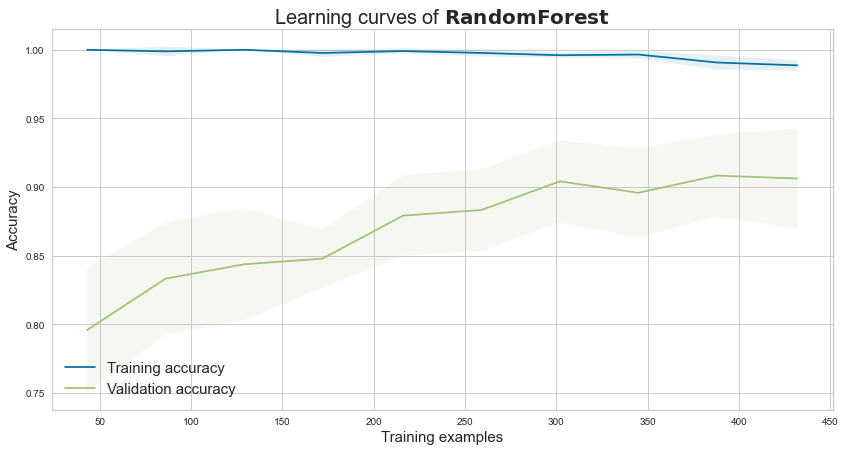

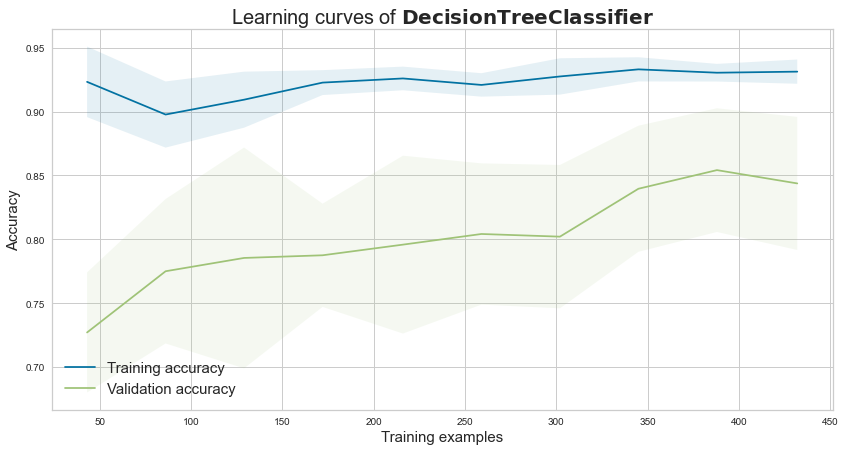

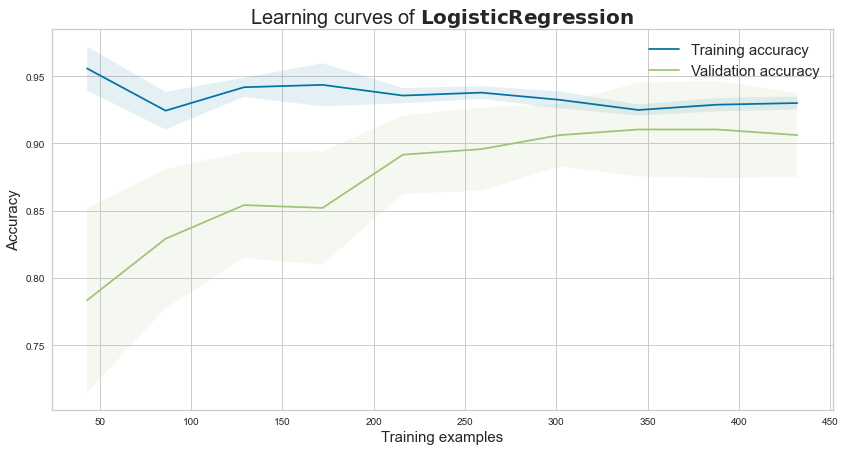

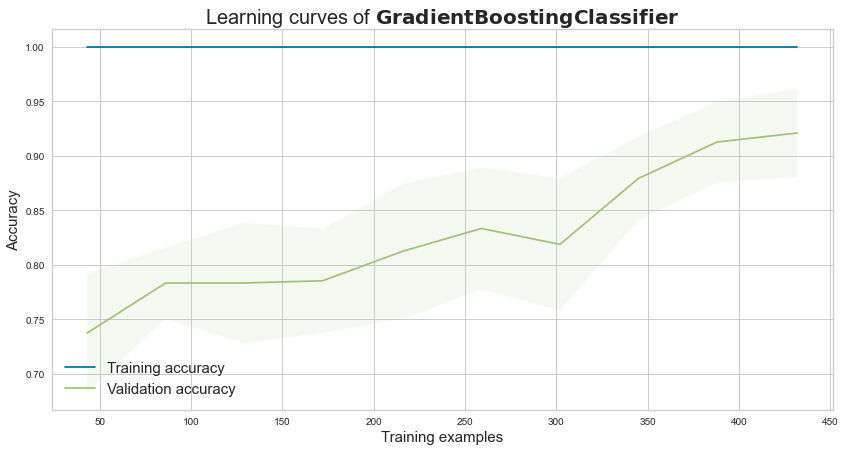

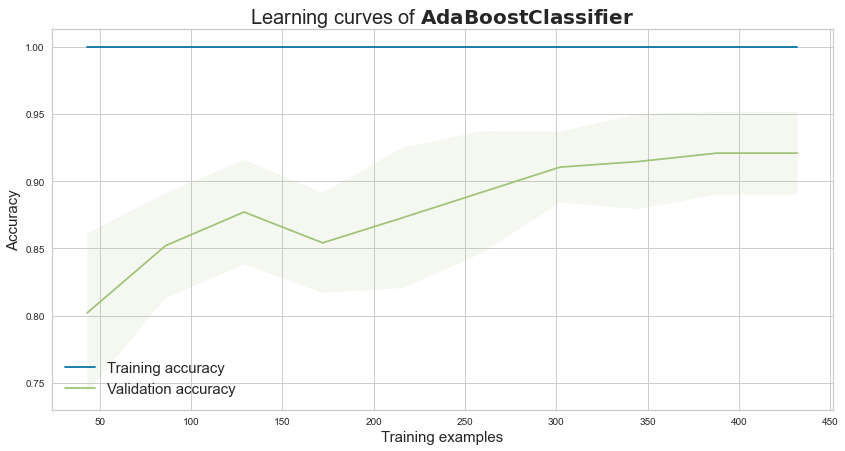

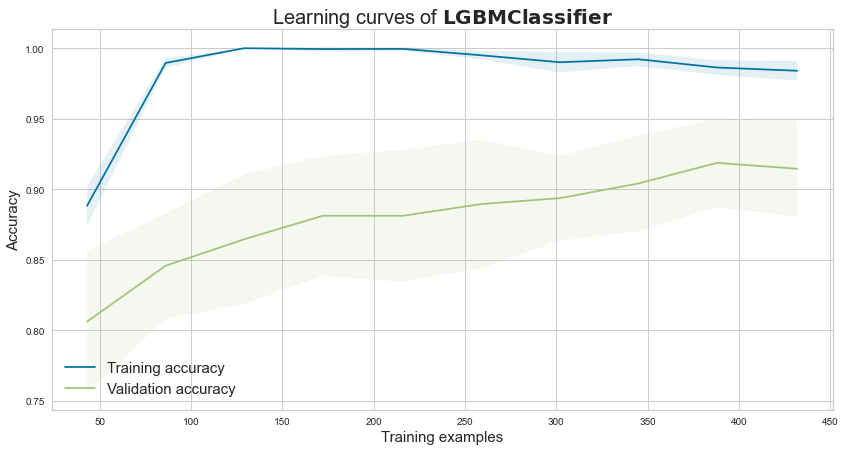

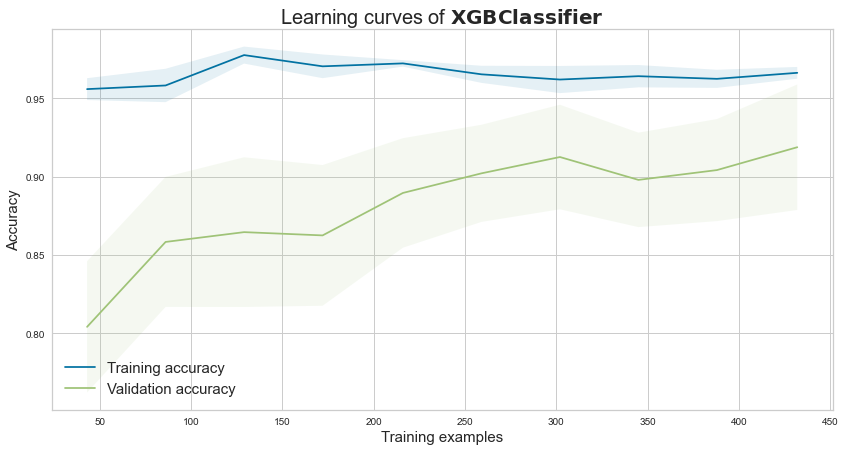

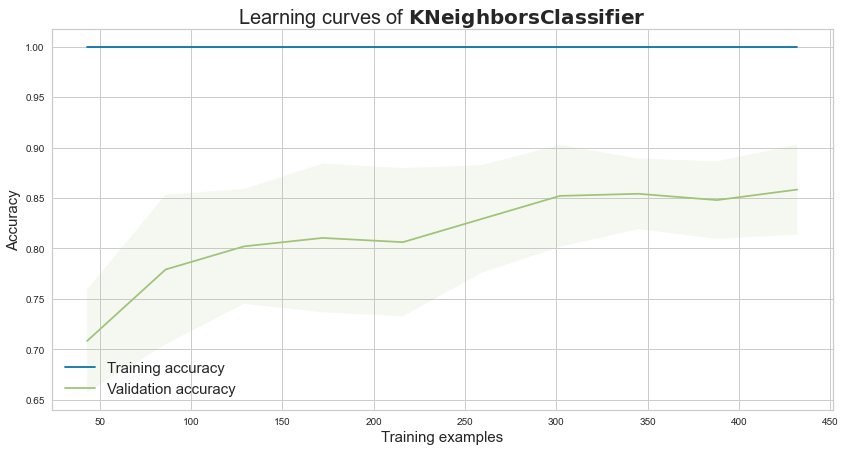

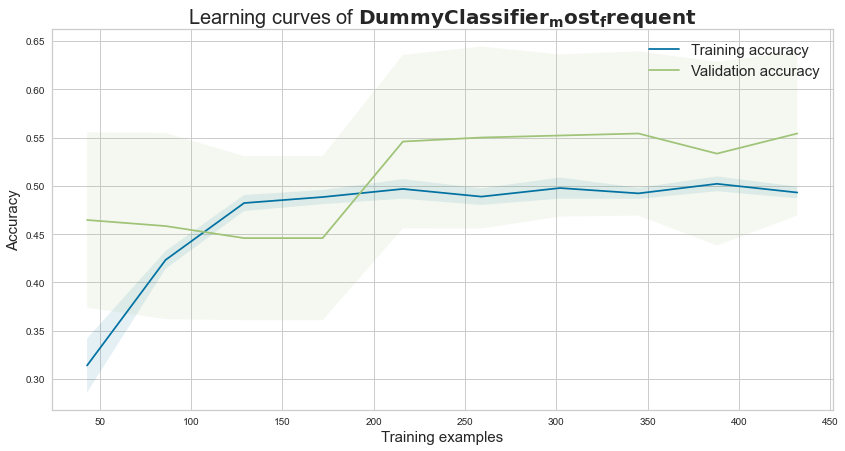

In [181]:
grid_list = []
for name, model, param_grid in models:
    file_name = name.replace(' ', '_')
    path = f'model/feature_importance/grid_search/grid_search_{file_name}.pkl'
    grid_search = joblib.load(path)

    grid_list.append((name,grid_search.best_estimator_))
    viz_learning_curve(name,grid_search.best_estimator_, X_train, y_train)

## Confusion Matrixes

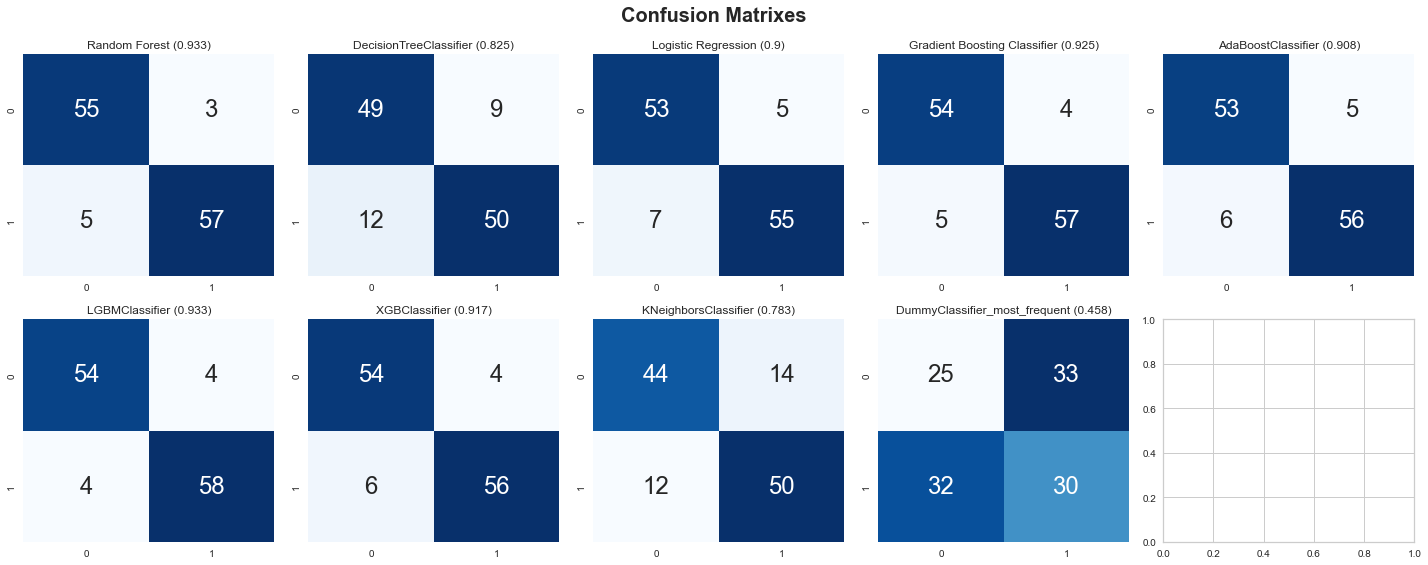

In [182]:
n_rows = 2
n_cols = 5
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
fig.suptitle('Confusion Matrixes', fontsize=20, fontweight='bold')
index = 0
for name, model in grid_list:
    row = index // n_cols
    col = index % n_cols
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    axes[row][col].set_title(f'{name} ({accuracy.round(3)})')
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", ax=axes[row][col],
                cbar=False, annot_kws={"size": 24})
    index+=1
plt.tight_layout()
plt.show()

## ROC 

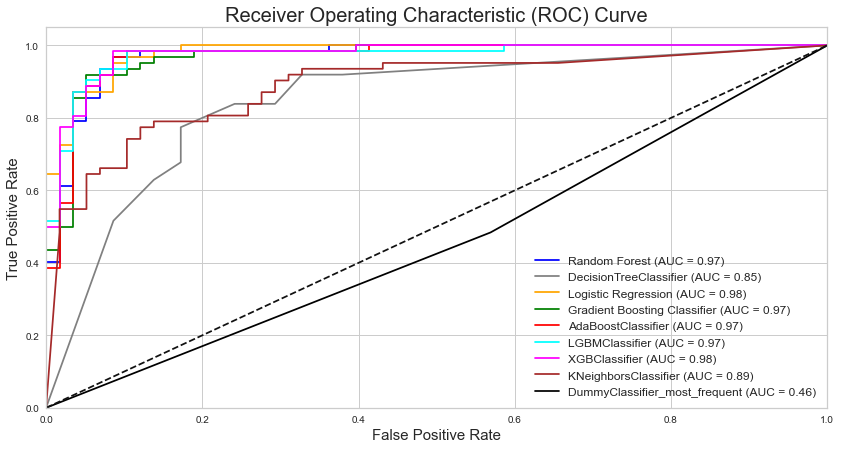

In [179]:
fig = plt.figure(figsize=(14, 7))

for model_name, model in grid_list:
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    auc_score = roc_auc_score(y_test, y_test_prob)
    color = color_mapping[model_name]
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})',color = color)

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
plt.legend(loc='lower right', fontsize=12)

plt.show()

In [180]:
final_performances

Model Runtime Performance       AUC   TP   FP  \
0                   Random Forest    0.86       Train  0.981197  239    3   
1                   Random Forest    0.86        Test  0.925195   54    4   
2          DecisionTreeClassifier    0.09       Train  0.933155  231   11   
3          DecisionTreeClassifier    0.09        Test  0.908509   53    5   
4             Logistic Regression    0.07       Train  0.922825  226   16   
5             Logistic Regression    0.07        Test  0.909622   55    3   
6    Gradient Boosting Classifier     2.6       Train  1.000000  242    0   
7    Gradient Boosting Classifier     2.6        Test  0.899889   52    6   
8              AdaBoostClassifier    0.65       Train  1.000000  242    0   
9              AdaBoostClassifier    0.65        Test  0.917130   54    4   
10                 LGBMClassifier    3.16       Train  0.974859  240    2   
11                 LGBMClassifier    3.16        Test  0.908509   53    5   
12                  XGBClassifier   20.24       Train  0.960223  238    4   
13                  XGBClassifier   20.24        Test  0.925195   54    4   
14           KNeighborsClassifier    0.51       Train  1.000000  242    0   
15           KNeighborsClassifier    0.51        Test  0.841212   48   10   
16  DummyClassifier_most_frequent     0.0       Train  0.491597  121  121   
17  DummyClassifier_most_frequent     0.0        Test  0.457453   25   33   

     FN   TN  Precision    Recall  Accuracy  
0     6  232   0.981323  0.981250  0.981250  
1     5   57   0.925160  0.925000  0.925000  
2    21  217   0.934064  0.933333  0.933333  
3     6   56   0.908498  0.908333  0.908333  
4    21  217   0.923087  0.922917  0.922917  
5     8   54   0.911431  0.908333  0.908333  
6     0  238   1.000000  1.000000  1.000000  
7     6   56   0.900000  0.900000  0.900000  
8     0  238   1.000000  1.000000  1.000000  
9     6   56   0.917222  0.916667  0.916667  
10   10  228   0.975522  0.975000  0.975000  
11    6   56   0.908498  0.908333  0.908333  
12   15  223   0.961372  0.960417  0.960417  
13    5   57   0.925160  0.925000  0.925000  
14    0  238   1.000000  1.000000  1.000000  
15    9   53   0.841674  0.841667  0.841667  
16  123  115   0.491631  0.491667  0.491667  
17   32   30   0.458020  0.458333  0.458333

# Conclusion

### Considering Model the Best Performance
<u>**Anwser**</u> **Logistic Regression** 
- **Learning curve** = **`Good Fit`** model is `performing well` and is `able` to `generalize` to new data.
- **Logistic Regression**'s **Accuracy** = Test set (0.88) worse than Others, But ability to distinguish is High (AUC = 0.97)
- **Run time** = All is 0.01 s